# MSIN0114  Independent project

# Customer purchase behaviour mining through clustering and classification 

In [1]:
# Visualisation packages 
! pip -q install missingno

# ML packages 
! pip -q install pyclustertend
! pip -q install kmodes
! pip -q install yellowbrick
! pip -q install scikit-learn-extra


         .:::.     .::.       
        ....yy:    .yy.       
        :.  .yy.    y.        
             :y:   .:         
             .yy  .:          
              yy..:           
              :y:.            
              .y.             
             .:.              
        ....:.                
        :::.                  

• Project files and data should be stored in /project. This is shared among everyone
  in the project.
• Personal files and configuration should be stored in /home/faculty.
• Files outside /project and /home/faculty will be lost when this server is terminated.
• Create custom environments to setup your servers reproducibly.


         .:::.     .::.       
        ....yy:    .yy.       
        :.  .yy.    y.        
             :y:   .:         
             .yy  .:          
              yy..:           
              :y:.            
              .y.             
             .:.              
        ....:.                
        :::.       

In [2]:
# Import all relevant modules and codes 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
#import chart_studio.plotly as py
#from plotly.offline import iplot
import seaborn as sns
import missingno as msno 
import datetime as dt

# Pretty display for notebooks
%matplotlib inline

# Import ML libraries for clustering 
import sklearn
import scipy
import time 
import scipy.cluster.hierarchy as sch
import matplotlib.cm as cm
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import scale 
from pyclustertend import hopkins
from pyclustertend import assess_tendency_by_mean_metric_score 
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer 
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from scipy.cluster.hierarchy import dendrogram,linkage 
from sklearn.cluster import AgglomerativeClustering
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.metrics.cluster import homogeneity_score
from sklearn_extra.cluster import KMedoids


# For classification 
from sklearn import metrics 
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA 
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB
from scipy import stats
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score,cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix, plot_roc_curve, accuracy_score


# Supress warnings
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
warnings.filterwarnings('ignore')
pd.set_option('mode.chained_assignment', None) # avoid settingwithcopywarning 

# Display all outputs 

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


# 0. Workbook structure 

Structure of this notebook is set as follows: 
- Data acquisition 
	- Description 
	- Inspection 
	- Initial data cleaning 
- Exploratory data analysis 
- Modelling 
	- Part 1: customer segmentation with clustering 
		- Data preparation 
			- Outlier detection 
			- Log transformation 
			- Manual labelling 
        - Model implementation  
            - K-means
			- Hierarchical clustering 
			- K-medoids
			- Performance comparison 
	- Part 2: Classification 
        - Data preparation 
			- Target variable 
			- Feature engineering 
			- Feature selection 
			- Class imbalance 
		- Model implementation 
			- Training models in their default setting 
			- Fine tuning 
			- Performance evaluation 
			
			  

# 1. Data acquisition 

## Description 

- The dataset used in this project can be accessed from UCI: https://archive.ics.uci.edu/ml/datasets/Online+Retail+II
- It captures transactional data occured in a UK-based and registered all-occasion giftware online store from 2009 December to 2011 December. 

Arrtribute info (8): 
- InvoiceNo: Invoice number. Nominal. A 6-digit integral number uniquely assigned to each transaction. If this code starts with the letter 'c', it indicates a cancellation. 
- StockCode: Product (item) code. Nominal. A 5-digit integral number uniquely assigned to each distinct product. 
- Description: Product (item) name. Nominal. 
- Quantity: The quantities of each product (item) per transaction. Numeric. 
- InvoiceDate: Invice date and time. Numeric. The day and time when a transaction was generated. 
- UnitPrice: Unit price. Numeric. Product price per unit in sterling (Â£). 
- CustomerID: Customer number. Nominal. A 5-digit integral number uniquely assigned to each customer. 
- Country: Country name. Nominal. The name of the country where a customer resides.

## Inspection

The original data is stored in 2 separate excel worksheets. I concatenated them based on common columns and then saved them as a data frame in csv format.

In [3]:
# Read in 2 sheets from excel  
#a=pd.read_excel('online_retail_II.xlsx', sheet_name='Year 2009-2010')
#b=pd.read_excel('online_retail_II.xlsx', sheet_name='Year 2010-2011')

# Concatenate the sheets into one dataframe  
#df=pd.concat([a,b],ignore_index=True)

#df.to_csv('retail.csv',index=False)

In [4]:
# Read in the dataframe 
df=pd.read_csv('retail.csv')

# Make a copy 
df_a=df.copy()

In [5]:
# Basic info
df_a.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1067371 non-null  object 
 1   StockCode    1067371 non-null  object 
 2   Description  1062989 non-null  object 
 3   Quantity     1067371 non-null  int64  
 4   InvoiceDate  1067371 non-null  object 
 5   Price        1067371 non-null  float64
 6   Customer ID  824364 non-null   float64
 7   Country      1067371 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 65.1+ MB


In [6]:
# Missing value 
df_a.isnull().sum()/len(df_a)

Invoice        0.000000
StockCode      0.000000
Description    0.004105
Quantity       0.000000
InvoiceDate    0.000000
Price          0.000000
Customer ID    0.227669
Country        0.000000
dtype: float64

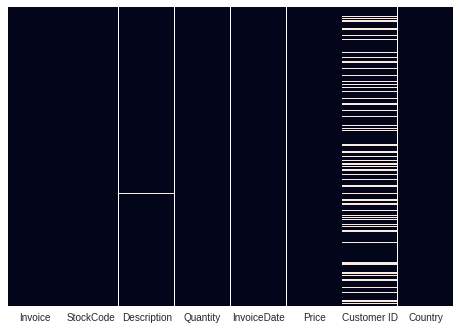

In [7]:
# Visualise the completeness of dataframe 
sns.heatmap(df_a.isnull(), cbar=False, yticklabels=False);

In [8]:
# Check the number of unique value of each variable 
df_a.nunique()

Invoice        53628
StockCode       5305
Description     5698
Quantity        1057
InvoiceDate    47635
Price           2807
Customer ID     5942
Country           43
dtype: int64

In [9]:
# First ten rows 
df_a.head(10)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
5,489434,22064,PINK DOUGHNUT TRINKET POT,24,2009-12-01 07:45:00,1.65,13085.0,United Kingdom
6,489434,21871,SAVE THE PLANET MUG,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
7,489434,21523,FANCY FONT HOME SWEET HOME DOORMAT,10,2009-12-01 07:45:00,5.95,13085.0,United Kingdom
8,489435,22350,CAT BOWL,12,2009-12-01 07:46:00,2.55,13085.0,United Kingdom
9,489435,22349,"DOG BOWL , CHASING BALL DESIGN",12,2009-12-01 07:46:00,3.75,13085.0,United Kingdom


There are nearly 53k orders made by approximately 6k customers from 43 different countries. The store offers 5,305 unique products (with 5698 distinct product descriptions).   

## Initial data cleaning 

The following presents some data cleaning steps performed. 

### *Column name*

In [10]:
# Change all column name to lower case to facilitate dot reference
df_a.columns = df_a.columns.str.lower()
df_a.rename(columns={'customer id':'customer_id'},inplace=True)

### *Handle missing values* 

In [11]:
# Convert customer id to integer 
df_a['customer_id']=df_a['customer_id'].astype(str)

In [12]:
# Drop rows with missing customer id 
df_a=df_a.loc[df_a.customer_id!='nan']

### *Remove cancelled orders*

In [13]:
# Find cancelled orders start with C 
df_a['invoice'].apply(lambda x:int('C' in x)).sum()

18744

In [14]:
# Save for later exploration 
df_cancelled=df_a[df_a.invoice.str.contains('C')]

In [15]:
# Remove them from the original dataframe
df_a=df_a[~df_a.invoice.str.contains('C')]

### *Remove incomplete month*

In [16]:
# Earliest date should not be before 2009.12.1 
df_a.invoicedate.min()

# Latest date should not be later than 2011.12.09
df_a.invoicedate.max()

'2009-12-01 07:45:00'

'2011-12-09 12:50:00'

In [17]:
# To compare all monthly features on the same scale drop incomplete month 
df_a=df_a.loc[df_a.invoicedate < '2011-12-01']

### *Remove duplicates*

In [18]:
# Check duplicate rows 
df_a.duplicated().sum()

25847

In [19]:
# Drop duplicated rows
df_a = df_a.drop_duplicates()

### *Create new variable*

In [20]:
# Create 'amount' variable 
df_a['amount']=df_a['price']*df_a['quantity']

In [21]:
# Stats of numeric variables
df_a.describe()

,quantity,price,amount
count,762468.000000,762468.000000,762468.000000
mean,13.432599,3.228978,22.109250
std,115.392732,29.942888,124.584979
min,1.000000,0.000000,0.000000
25%,2.000000,1.250000,4.950000
50%,6.000000,1.950000,12.500000
75%,12.000000,3.750000,19.800000
max,74215.000000,10953.500000,77183.600000


In [22]:
# Drop free products 
free=df_a.loc[(df_a.price==0)]
df_a=df_a[(df_a.price>0) ]

### *Check product type*

In [23]:
# Transaction types to check 
types=df_a[df_a['stockcode'].str.contains('^[a-zA-Z]+', regex=True)]['stockcode'].unique()

In [24]:
# Number of rows containing string stockcode
for x in types:
    print("{:<15} -> {:<30} -> {} entries".format(x, df_a[df_a['stockcode'] == x]['description'].unique()[0],len(df_a[df_a.stockcode==x])))

POST            -> POSTAGE                        -> 1753 entries
C2              -> CARRIAGE                       -> 245 entries
M               -> Manual                         -> 673 entries
BANK CHARGES    ->  Bank Charges                  -> 30 entries
TEST001         -> This is a test product.        -> 9 entries
TEST002         -> This is a test product.        -> 1 entries
PADS            -> PADS TO MATCH ALL CUSHIONS     -> 17 entries
ADJUST          -> Adjustment by john on 26/01/2010 16 -> 32 entries
D               -> Discount                       -> 5 entries
ADJUST2         -> Adjustment by Peter on Jun 25 2010  -> 3 entries
SP1002          -> KID'S CHALKBOARD/EASEL         -> 2 entries
DOT             -> DOTCOM POSTAGE                 -> 15 entries


The above shows all string stockcode contained in the dataset. We see for those labelled 'M','Test001','TEST002','SP1002','PADS', they are  product-related. But for the remaining codes like 'POST' and 'Bank charges', idelly,they should be excluded when counting product diversity in an order. However, for simplicity, they are not removed in my first attempt. If product diversity or quantity turns out to be a crucial variable, then further adjustment should be made in future work.

### *Convert data type and Extract temporal variables - Month, Day and Hour*

In [25]:
# Convert invoice date to datetime 
df_a['invoicedate']=pd.to_datetime(df_a['invoicedate'])

In [26]:
# Extract year,month, date, time, hour
df_a['year']=df_a['invoicedate'].dt.year
df_a['date']=df_a['invoicedate'].dt.date
df_a['time']=df_a['invoicedate'].dt.time
df_a['month']=df_a['invoicedate'].dt.month
df_a['hour']=df_a['invoicedate'].dt.hour

In [27]:
# Get the weekday of the date and month year 
df_a['dow']=pd.to_datetime(df_a['date']).dt.day_name()
df_a['my'] =pd.to_datetime(df_a['date']).dt.to_period('M')

In [28]:
# Change the notation 
weekday=['Monday','Tuesday','Wednesday','Thursday','Friday']
weekend=['Saturday','Sunday']
df_a['week_day']=np.where(df_a['dow'].isin(weekday),'weekday','weekend')

In [29]:
# Change data type 
#for i in ['year','month','hour']:
#    df_a[i]=df_a[i].astype(str)

### *Detect extreme values*

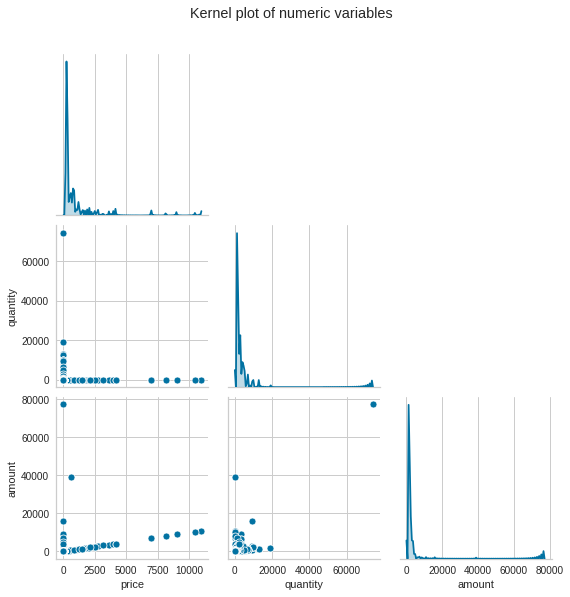

In [30]:
# Kernel density plot of numeric variables 
f=sns.pairplot(df_a[['price','quantity','amount']],diag_kind="kde", corner=True)
f.fig.suptitle('Kernel plot of numeric variables',y=1.08)
plt.show();

Though the transaction records are genuine, outliers can be observed which require further processing before passing to the models. Currently, these records are kept for exploration purposes. 

In [31]:
# Take a look at transactions with these extreme values 
df_a[df_a['price']>5000]
df_a[df_a['quantity']>10000]

,invoice,stockcode,description,quantity,invoicedate,price,customer_id,country,amount,year,date,time,month,hour,dow,my,week_day
74356,496115,M,Manual,1,2010-01-29 11:04:00,8985.60,17949.0,United Kingdom,8985.60,2010,2010-01-29,11:04:00,1,11,Friday,2010-01,weekday
129903,501766,M,Manual,1,2010-03-19 11:35:00,6958.17,15760.0,Norway,6958.17,2010,2010-03-19,11:35:00,3,11,Friday,2010-03,weekday
129987,501768,M,Manual,1,2010-03-19 11:45:00,6958.17,15760.0,Norway,6958.17,2010,2010-03-19,11:45:00,3,11,Friday,2010-03,weekday
135013,502263,M,Manual,1,2010-03-23 15:22:00,10953.50,12918.0,United Kingdom,10953.50,2010,2010-03-23,15:22:00,3,15,Tuesday,2010-03,weekday
358639,524159,M,Manual,1,2010-09-27 16:12:00,10468.80,14063.0,United Kingdom,10468.80,2010,2010-09-27,16:12:00,9,16,Monday,2010-09,weekday
698843,551697,POST,POSTAGE,1,2011-05-03 13:46:00,8142.75,16029.0,United Kingdom,8142.75,2011,2011-05-03,13:46:00,5,13,Tuesday,2011-05,weekday


,invoice,stockcode,description,quantity,invoicedate,price,customer_id,country,amount,year,date,time,month,hour,dow,my,week_day
90857,497946,37410,BLACK AND WHITE PAISLEY FLOWER MUG,19152,2010-02-15 11:57:00,0.10,13902.0,Denmark,1915.2,2010,2010-02-15,11:57:00,2,11,Monday,2010-02,weekday
127166,501534,21099,SET/6 STRAWBERRY PAPER CUPS,12960,2010-03-17 13:09:00,0.10,13902.0,Denmark,1296.0,2010,2010-03-17,13:09:00,3,13,Wednesday,2010-03,weekday
127167,501534,21092,SET/6 STRAWBERRY PAPER PLATES,12480,2010-03-17 13:09:00,0.10,13902.0,Denmark,1248.0,2010,2010-03-17,13:09:00,3,13,Wednesday,2010-03,weekday
127168,501534,21091,SET/6 WOODLAND PAPER PLATES,12960,2010-03-17 13:09:00,0.10,13902.0,Denmark,1296.0,2010,2010-03-17,13:09:00,3,13,Wednesday,2010-03,weekday
127169,501534,21085,SET/6 WOODLAND PAPER CUPS,12744,2010-03-17 13:09:00,0.10,13902.0,Denmark,1274.4,2010,2010-03-17,13:09:00,3,13,Wednesday,2010-03,weekday
587080,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom,77183.6,2011,2011-01-18,10:01:00,1,10,Tuesday,2011-01,weekday


In [32]:
# Make a copy of the cleaned dataframe 
df_b=df_a.copy()

# 2. Exploratory data analysis 

### Time series 

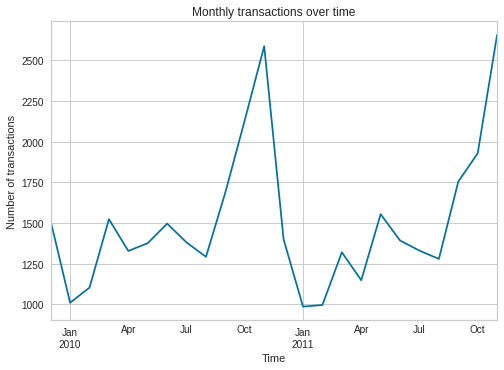

In [33]:
# Number of orders by month 
monthly=pd.DataFrame(df_b[['my','invoice']]).groupby(['my'])['invoice'].nunique()

# Plot
monthly.plot(kind='line', title='Monthly transactions over time',legend=None)
plt.ylabel('Number of transactions');plt.xlabel('Time')
plt.show();

### Order by day of the week 

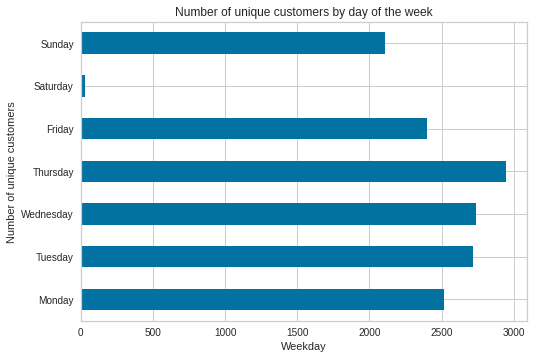

In [34]:
# Number of vistors by weekday 
visits_wk =pd.DataFrame(df_b.groupby(['dow'])['customer_id'].nunique())
visits_wk.rename(columns={'customer_id': 'customers'},inplace=True) 
wk=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
visits_wk=visits_wk.reindex(wk)

# Plot 
visits_wk.plot(kind='barh', legend=None, title='Number of unique customers by day of the week')
plt.ylabel('Number of unique customers');plt.xlabel('Weekday')
plt.show();

### Hour of the day 

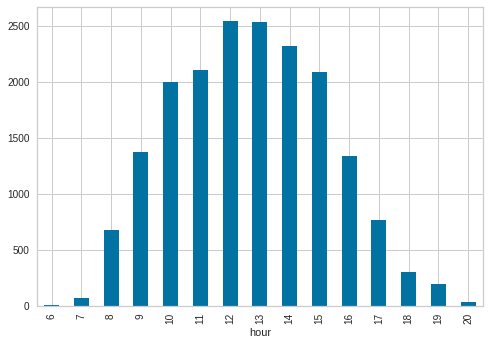

In [35]:
# Number of users by the hour of the day (bar chart)
visit_hr =pd.DataFrame(df_b.groupby(['hour'])['customer_id'].nunique())

# Plot 
visit_hr.plot(kind='bar',legend=None);

### Frequency of purchase

In [36]:
# Count unique number of invoices each customer has 
freq_purchase=pd.DataFrame(df_b[['customer_id','invoice']].groupby(['customer_id'])['invoice'].nunique()).reset_index()
freq_purchase.columns=['customer_id','freq_p']

# Find out the median (as median is less affected by extreme values)
median=freq_purchase['freq_p'].median()
median

3.0

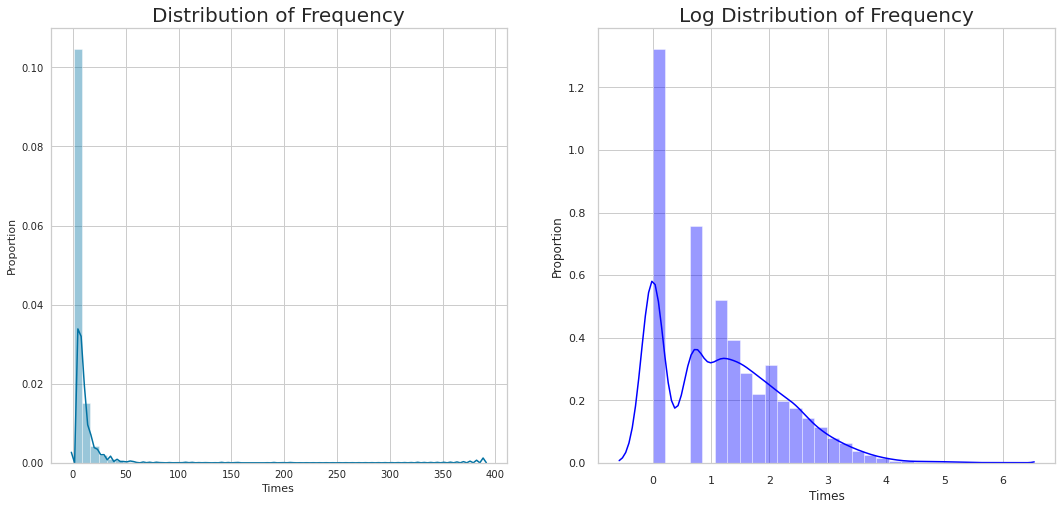

In [37]:
# Plot the distribution before and after log-transformation 
plt.rcParams['figure.figsize'] = (18, 8)

plt.subplot(1, 2, 1)
sns.set(style = 'whitegrid')
sns.distplot(freq_purchase['freq_p'])
plt.title('Distribution of Frequency', fontsize = 20)
plt.xlabel('Times')
plt.ylabel('Proportion')


plt.subplot(1, 2, 2)
sns.set(style = 'whitegrid')
sns.distplot(np.log(freq_purchase['freq_p']), color = 'blue')
plt.title('Log Distribution of Frequency', fontsize = 20)
plt.xlabel('Times')
plt.ylabel('Proportion')
plt.show();

In [38]:
# Class purchase frequency into 6 levels 
def conditions(df):
    if ((df['freq_p']>= 7)):
        return 'Euqal or more than six times'
    elif ((4<=df['freq_p']<=6)):
        return 'Four to six times'
    elif ((2<=df['freq_p']<=3)):
        return 'Two to three times'
    else:
        return 'Once only'
freq_purchase['freq_times']=freq_purchase.apply(conditions,axis=1)

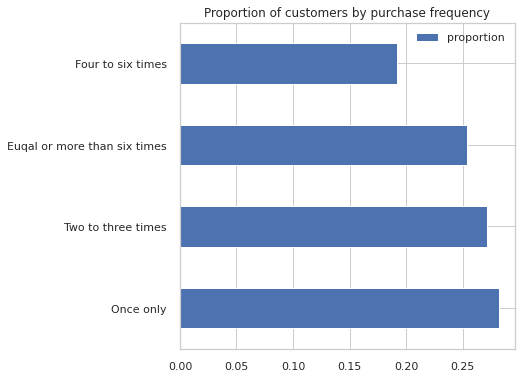

In [39]:
# Pie plot the distribution 
freq=pd.DataFrame(freq_purchase['freq_times'].value_counts()/freq_purchase['freq_times'].value_counts().sum())
freq.columns=['proportion']
freq.plot(kind='barh',figsize=(6,6))
plt.title('Proportion of customers by purchase frequency')
plt.ylabel("")
plt.show();

#### Country 

In [42]:
# Create dataframe with user and their residential country 
df_country=pd.DataFrame(df_b.drop_duplicates(subset=['customer_id']).country.value_counts().sort_values(ascending=False))
df_country.columns=['users']

# Find out the proportion of users from each country 
df_country['proportion']=(df_country['users']/df_country['users'].sum()).round(4)

# Print out the first 10 rows 
df_country.head(10)

,users,proportion
United Kingdom,5328,0.9108
Germany,106,0.0181
France,92,0.0157
Spain,38,0.0065
Belgium,27,0.0046
Portugal,24,0.0041
Netherlands,22,0.0038
Switzerland,21,0.0036
Sweden,19,0.0032
Italy,17,0.0029


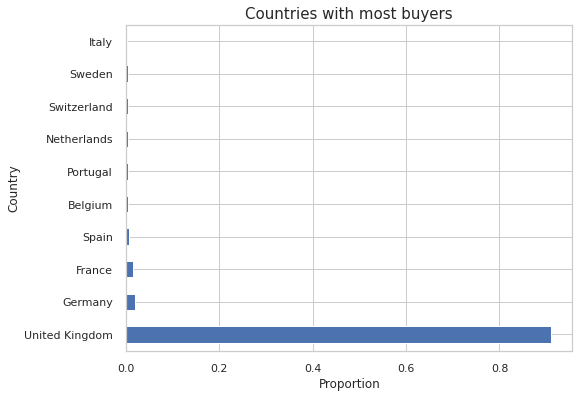

In [43]:
# plot 
df_country['proportion'].head(10).plot(kind='barh',figsize=(8,6))
plt.title('Countries with most buyers', fontsize = 15)
plt.xlabel('Proportion')
plt.ylabel('Country')
plt.show();

### Interpurchase timing

In [41]:
## Calculate the difference between login dates
diff_day=pd.DataFrame(df_b[['customer_id','date']]).drop_duplicates()
# calculate the difference between each unique date by user 
diff_day['diff']=diff_day.groupby('customer_id')['date'].diff(-1) * (-1)

# Since we have a lot of empty values for users with one record only,
# fill those by subtract the date from Dec.1
start=pd.to_datetime(dt.date(2011,12,1))
diff_day.loc[diff_day["diff"].isnull(),'diff'] = start-pd.to_datetime(diff_day["date"])
diff_day['diff']=diff_day['diff'].dt.days
diff_day['diff']

0            2
12           7
31         290
54           2
71           7
          ... 
1041577      1
1041600      1
1041615      1
1041651      1
1041683      1
Name: diff, Length: 32401, dtype: int64

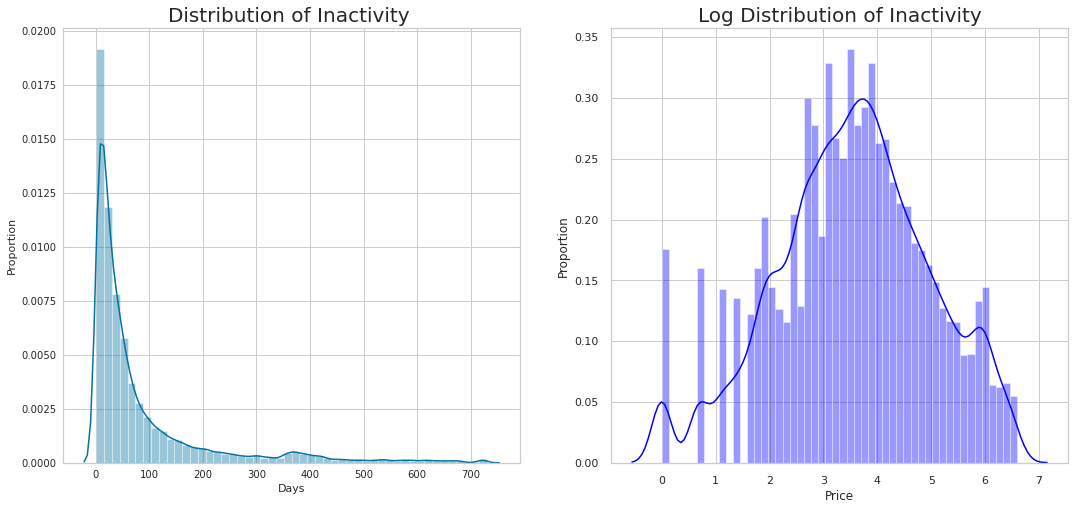

In [42]:
# Plot the distribution before and after log-transformation 
plt.rcParams['figure.figsize'] = (18, 8)

plt.subplot(1, 2, 1)
sns.set(style = 'whitegrid')
sns.distplot(diff_day['diff'])
plt.title('Distribution of Inactivity ', fontsize = 20)
plt.xlabel('Days')
plt.ylabel('Proportion')


plt.subplot(1, 2, 2)
sns.set(style = 'whitegrid')
sns.distplot(np.log(diff_day['diff']), color = 'blue')
plt.title('Log Distribution of Inactivity', fontsize = 20)
plt.xlabel('Price')
plt.ylabel('Proportion')
plt.show();

### Quantity 

In [43]:
# Calculate the total number of products purchased by each user 
quantity_purchased=df_b[['customer_id','quantity']].groupby('customer_id')['quantity'].sum()

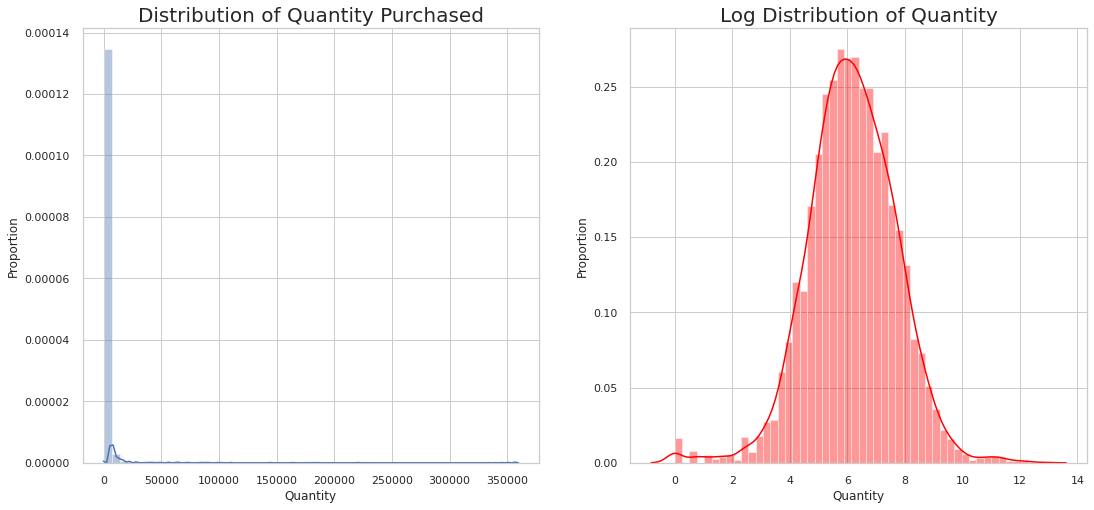

In [44]:
# Plot the distribution before and after log-transformation 
plt.rcParams['figure.figsize'] = (18, 8)

plt.subplot(1, 2, 1)
sns.set(style = 'whitegrid')
sns.distplot(quantity_purchased)
plt.title('Distribution of Quantity Purchased', fontsize = 20)
plt.xlabel('Quantity')
plt.ylabel('Proportion')


plt.subplot(1, 2, 2)
sns.set(style = 'whitegrid')
sns.distplot(np.log(quantity_purchased), color = 'red')
plt.title('Log Distribution of Quantity', fontsize = 20)
plt.xlabel('Quantity')
plt.ylabel('Proportion')
plt.show();

### Value per order 

In [45]:
# Purchase value per order
session_value=pd.DataFrame(df_b.groupby(['invoice'])['amount'].sum())

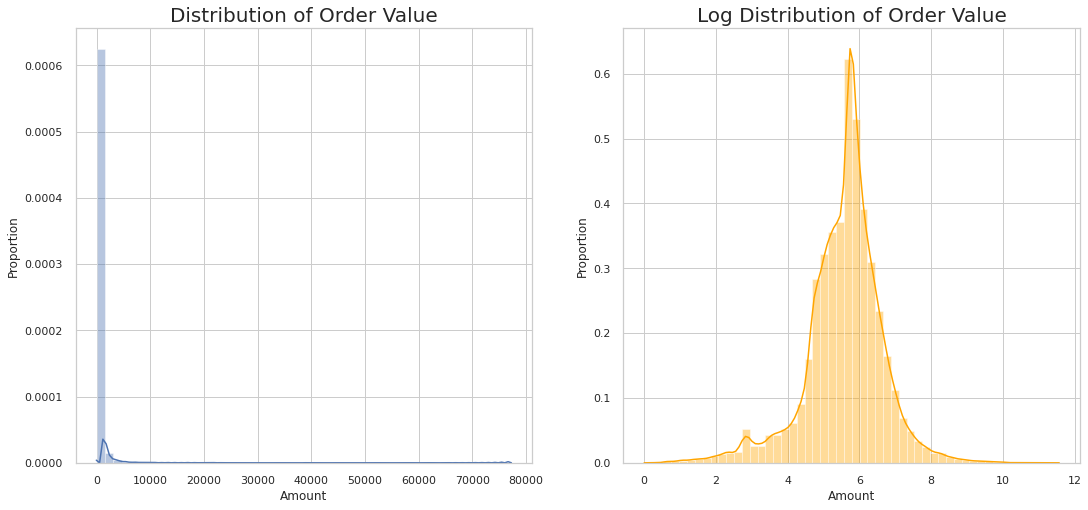

In [46]:
# Plot the distribution before and after log-transformation 
plt.rcParams['figure.figsize'] = (18, 8)

plt.subplot(1, 2, 1)
sns.set(style = 'whitegrid')
sns.distplot(session_value)
plt.title('Distribution of Order Value', fontsize = 20)
plt.xlabel('Amount')
plt.ylabel('Proportion')


plt.subplot(1, 2, 2)
sns.set(style = 'whitegrid')
sns.distplot(np.log(session_value+1), color = 'orange',)
plt.title('Log Distribution of Order Value', fontsize = 20)
plt.xlabel('Amount')
plt.ylabel('Proportion')
plt.show();

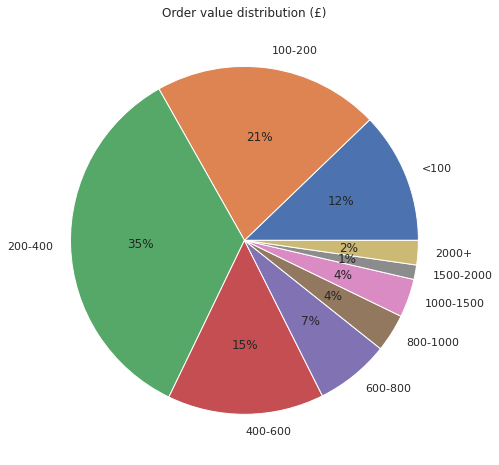

In [47]:
# Bin the order values 
bins=[0,100,200,400,600,800,1000,1500,2000,17000]
session_value['binned']=pd.cut(session_value.amount,bins)
labels=["<100","100-200","200-400","400-600","600-800","800-1000",'1000-1500','1500-2000','2000+']
# plot the distribution 
session_value['binned'].value_counts().sort_index(ascending=True).plot(kind='pie',autopct='%1.0f%%',labels=labels,figsize=(10,8))
plt.ylabel("")
plt.title('Order value distribution (£)')
plt.show();

### Pareto rule 

Pareto rule in business context suggests that 80% of the business revenue may come from 20% of the customers. So I want to check if this rule also applies to the business. 

In [48]:
### Pareto rule 
money=pd.DataFrame(df_b.groupby('customer_id')['amount'].sum().sort_values(ascending=False))
money['perct']=100*money.amount/money.amount.sum()
money['cum_perct']=money['perct'].cumsum()
len(money[money.cum_perct<80])/len(money) 
# 23% of the customers made of 80% of the sales

0.23247863247863249

### Ten most purchased products 

In [49]:
# Top popular products in terms of unique buyers 
top10=pd.DataFrame(df_b.groupby(['description'])['customer_id'].nunique().sort_values(ascending=False).head(10))
top10.columns=['Number of buyers']
top10

,Number of buyers
description,
WHITE HANGING HEART T-LIGHT HOLDER,1487
REGENCY CAKESTAND 3 TIER,1307
BAKING SET 9 PIECE RETROSPOT,1126
ASSORTED COLOUR BIRD ORNAMENT,1003
PARTY BUNTING,892
HEART OF WICKER SMALL,880
PAPER CHAIN KIT 50'S CHRISTMAS,878
NATURAL SLATE HEART CHALKBOARD,863
JUMBO BAG RED RETROSPOT,854


### Cohort analysis 

Conduct cohort analysis to get an overview of the activeness of customers registered in different months.

In [50]:
# New dataframe with variables needed  
cohort=df_b[['customer_id','invoicedate','month','my']]

In [51]:
# Find the month of registration 
cohort['cohortmonth']=cohort.groupby('customer_id')['my'].transform('min')

In [52]:
# Define a function to get target year,month, day
def get_m_y(df,column):
    year=df[column].dt.year
    month=df[column].dt.month
    day=df[column].dt.day
    return year, month,day

invoice_yr,invoice_m,_=get_m_y(cohort,'invoicedate')
cohort_yr,cohort_m,_=get_m_y(cohort,'cohortmonth')
yr_diff=invoice_yr-cohort_yr
m_diff=invoice_m-cohort_m

In [53]:
# Compute the cohort index 
cohort['cohortindex']=yr_diff*12+m_diff+1

In [54]:
# Count monthly active customers from each cohort 
grouping=cohort.groupby(['cohortmonth','cohortindex'])
cohort_data=grouping['customer_id'].apply(pd.Series.nunique)
cohort_data=cohort_data.reset_index()
cohort_counts=cohort_data.pivot(index='cohortmonth',
                               columns='cohortindex',
                               values='customer_id')

#### Calculate retention rate 

Retention rate is the proportion of customers active divided by the total number of customers in that cohort. 

In [55]:
# Find the cohort sizes 
cohort_sizes=cohort_counts.iloc[:,0]
cohort_sizes

# Divide all by original cohort size in the first column 
retention=cohort_counts.divide(cohort_sizes,axis=0).round(3)

cohortmonth
2009-12    955.0
2010-01    383.0
2010-02    374.0
2010-03    443.0
2010-04    294.0
2010-05    254.0
2010-06    270.0
2010-07    186.0
2010-08    162.0
2010-09    243.0
2010-10    377.0
2010-11    325.0
2010-12     76.0
2011-01     71.0
2011-02    124.0
2011-03    179.0
2011-04    106.0
2011-05    111.0
2011-06    108.0
2011-07    102.0
2011-08    106.0
2011-09    189.0
2011-10    221.0
2011-11    191.0
Freq: M, Name: 1, dtype: float64

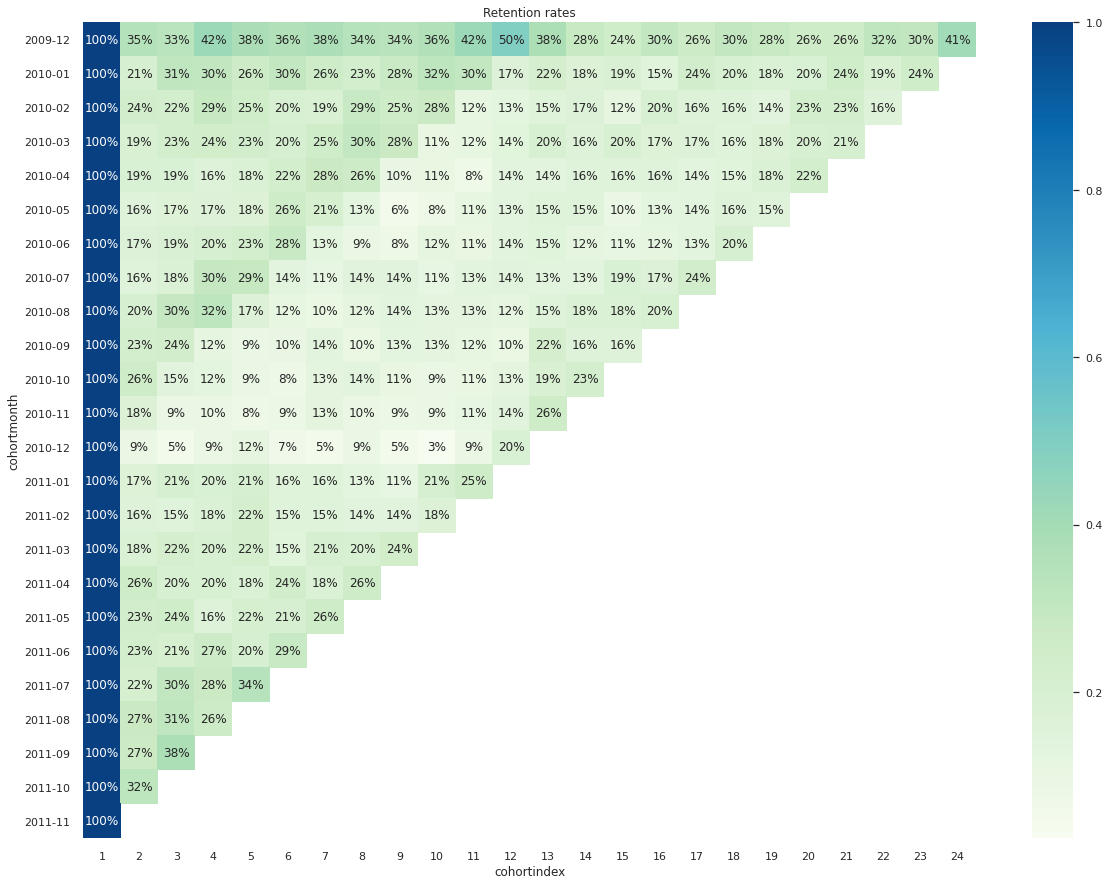

In [56]:
# Plot the heatmap by cohort retention
plt.figure(figsize=(20,15))
plt.title('Retention rates')
sns.heatmap(data=retention,
           annot=True,
            fmt='.0%',
           cmap='GnBu')
plt.show();

# 3. Modelling 

To avoid leakage of customer purchase information for training the purchase prediction classifer in Part 2, both clustering and classification will be based on transaction record before November 2011. 

In [57]:
# Remove all transactions occured in November 2011 
df_d=df_b[df_b['my']!='2011-11']

## Part 1: Customer segmentation with clustering 

### Data preparation 

In [58]:
# Compute RFM values for each customer
df_rfm=df_d.groupby('customer_id').agg({
    'date': lambda x:(dt.date(2011,11,1)-x.max()).days,
    'invoice':pd.Series.nunique,
    'amount':np.sum  
})
df_rfm.columns=['recency','frequency','monetary']

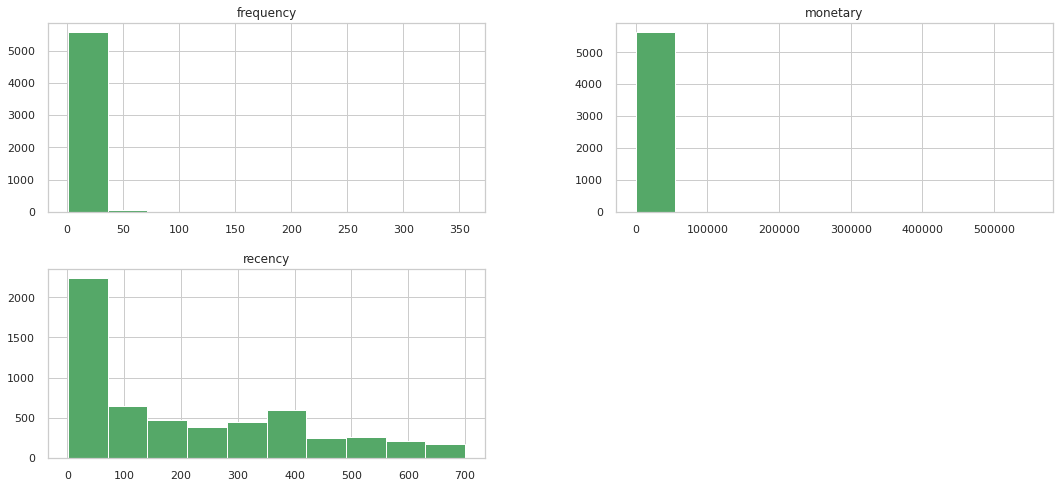

In [59]:
# Plot the distribution 
df_rfm.hist(color='g')
plt.show();

In [60]:
# Get the stats 
df_rfm.describe()

,recency,frequency,monetary
count,5659.000000,5659.000000,5659.000000
mean,204.644990,5.925782,2774.587421
std,195.613005,12.117217,13596.463912
min,1.000000,1.000000,2.900000
25%,33.000000,1.000000,325.000000
50%,134.000000,3.000000,817.250000
75%,356.000000,6.000000,2137.300000
max,700.000000,355.000000,554170.420000


### 'Outlier' detection 

Though all transactions are genuine, having extreme values may distort the performance of subsequent clustering and classification, therefore, outliers are checked and removed here. 

In [61]:
# Use IQR to detect outliers
Q1=df_rfm.quantile(0.25)
Q3=df_rfm.quantile(0.75)
IQR=Q3-Q1
print(IQR)

recency       323.0
frequency       5.0
monetary     1812.3
dtype: float64


In [62]:
# Dataframe without 'outliers'
df_rfm_out=df_rfm[~((df_rfm < (Q1 - 1.5 * IQR)) | (df_rfm > (Q3 + 1.5 * IQR))).any(axis=1)]
df_rfm_out.shape

(4932, 3)

In [63]:
# Summary stats 
df_rfm_out.describe()

,recency,frequency,monetary
count,4932.000000,4932.000000,4932.000000
mean,226.214112,3.357461,1031.670357
std,197.284801,2.795207,1024.198368
min,1.000000,1.000000,2.900000
25%,40.000000,1.000000,295.880000
50%,174.000000,2.000000,641.390000
75%,371.000000,5.000000,1433.152500
max,700.000000,13.000000,4851.440000


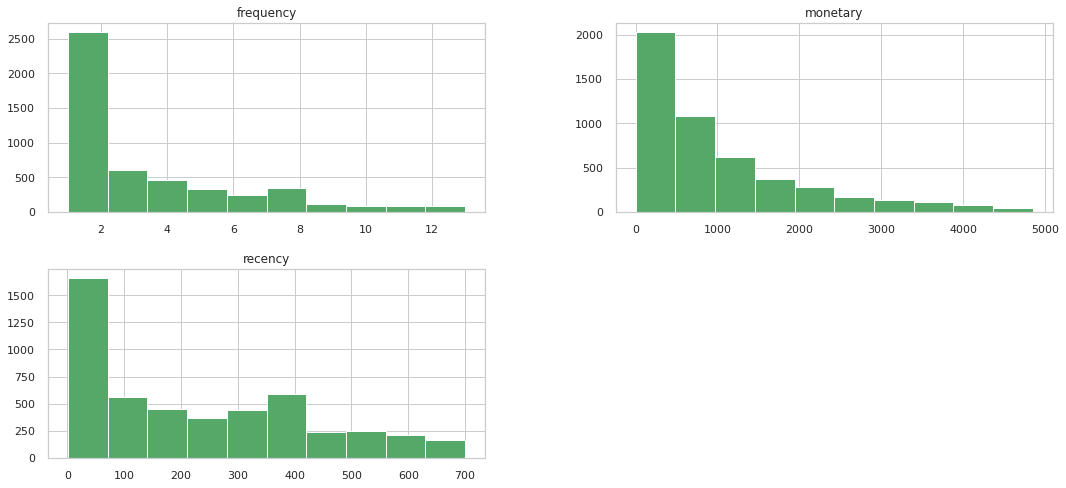

In [64]:
# Plot the distribution without outliers
df_rfm_out.hist(color='g')
plt.show();

### 'Outlier' inspection 

In [65]:
# Buyers considered as outliers 
outliers=df_rfm[~df_rfm.index.isin(df_rfm_out.index)]

In [66]:
# Stats of 'outliers'
outliers.describe()

,recency,frequency,monetary
count,727.00000,727.000000,727.000000
mean,58.31912,23.349381,14598.613505
std,96.20102,27.247040,35678.482217
min,1.00000,1.000000,167.420000
25%,11.00000,12.000000,5419.655000
50%,27.00000,17.000000,7325.360000
75%,55.00000,25.000000,11856.370000
max,653.00000,355.000000,554170.420000


From the statistical summary, most of these 727 customers are **high-spenders and frequent buyers**, so I guess they are likely to be **wholesalers** or **retailers**. They should be analysed and discussed separately from individual buyers because of their purchases habits are very different. The following proves my guess as **713 customers out of 727 are among the top 23% customers who contributed to 80% of the company's revenue**. 

In [67]:
# Check whether whether these 727 customers are among the top 23% customers 
top23=list(money.head(int(0.23*5850)).index)
outliers.index.isin(top23).sum()

713

### Log Transformation 

In [68]:
# Keep a copy of the no-outlier dataframe 
rfm_a=df_rfm_out.copy()

In [69]:
# Define power transformation function 
def powertransform(df):
    # Initiate PowerTransformer 
    trans=PowerTransformer()
    # Train the transfomer on the data 
    trans.fit(df)
    # Apply the power transform to the data 
    trans_rfm=trans.transform(df)
    trans_rfm=pd.DataFrame(data=trans_rfm,
                   columns=df.columns,
                   index=df.index)
    
    return trans_rfm

In [70]:
# Powertransform 
rfm_a1=powertransform(rfm_a)

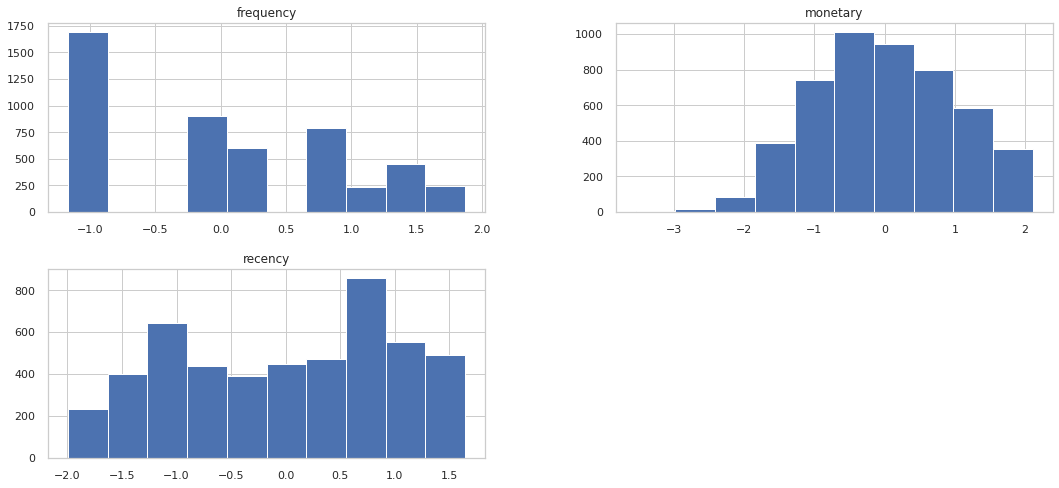

In [71]:
# Plot the distribution after transformation 
rfm_a1.hist()
plt.show();

In [72]:
# Check the skewness 
rfm_a1.skew()

recency     -0.192324
frequency    0.151277
monetary    -0.022756
dtype: float64

In [73]:
# Check whether the df is good for kmeans, mean of 0 and std of 1 
for i in [rfm_a1]:
    abs(i.agg(['mean','std']).round())

,recency,frequency,monetary
mean,0.0,0.0,0.0
std,1.0,1.0,1.0


This is the dataframe that will be passed to all three clustering algorithms. 

### *Manual labelling using RFM scoring methods* (For clustering results interpretation)

Before clustering, I decided to manual label some of the customers based on their distinguishing characteristics. For example: **loyal customers** are those who have high frequency and low recency value; **new customers** are those who have low recency and low frequency value;**churned customers** are those who have high recency value and low frequency value. 

All remaining customers whose purchase patterns are less obvious might need further exploration through clustering to see how similar they are to the other customers. For instance, they can be helpful for the business to understand whether these normal customers are more simialr to loyal customers or to churned already customers.

**Notice: These labels are not 'ground truth' labels to check clustering algorithms' performance as the boundary set is discretionary.**

In [74]:
# Create label on a separate df
rfm=df_rfm_out.copy()

In [75]:
# Assign each attribute of each customer with a score from 5 to 1 
# Score frequency using the mean scoring method
x=rfm[rfm['frequency']>1]
x['f1']=np.where(x['frequency']<x['frequency'].mean(),2,0)
x2=x[x.f1==0].drop('f1',axis=1)
x2['f2']=np.where(x2['frequency']<x2['frequency'].mean(),3,0)
x3=x2[x2.f2==0].drop('f2',axis=1)
x3['f3']=np.where(x3['frequency']<x3['frequency'].mean(),4,5)
rfm['f']=np.where(rfm.frequency==1,1,0)

In [76]:
# create the r_score column by merge the columns 
l='left'
keys=['recency','monetary','frequency']
rs=['f','f1','f2','f3']
rfm=pd.merge(rfm,x,how=l,on=keys).merge(x2,how=l,on=keys).merge(x3,how=l,on=keys)
rfm['f_score']=rfm[rs].sum(axis=1)
rfm.drop(rs,axis=1,inplace=True)
# change data type to int
rfm['f_score']=rfm['f_score'].astype(int)

In [77]:
# recency value is scored by the percentile approach 
rfm['r_rank'] = rfm['recency'].rank(ascending=True)
rfm['r_score'] = pd.qcut(rfm['r_rank'], 5, labels=range(5,0,-1))
rfm['m_rank'] = rfm['monetary'].rank(ascending=True)
rfm['m_score'] = pd.qcut(rfm['m_rank'], 5, labels=range(1,6,1))
rfm.drop(['r_rank','m_rank'],inplace=True, axis=1)

In [78]:
# Get the value for each quintile  
for i in [0.2,0.4,0.6,0.8,1]:
    print(rfm['recency'].quantile(i))
    print(rfm['monetary'].quantile(i))

32.0
237.786
106.0
465.51200000000006
264.0
882.7940000000002
397.0
1708.392
700.0
4851.439999999998


In [79]:
# Convert the data type 
rfm['m_score']=rfm['m_score'].astype(int)
rfm['r_score']=rfm['r_score'].astype(int)

In [80]:
# create the segment 
rfm['rfm_seg']=rfm['r_score'].astype(str)+rfm['f_score'].astype(str)+rfm['m_score'].astype(str)
# sum the scores for each user 
rfm['rfm_score'] = rfm[['r_score', 'f_score', 'm_score']].sum(axis = 1)
rfm.head()

,recency,frequency,monetary,f_score,r_score,m_score,rfm_seg,rfm_score
0,1,7,4696.71,3,5,5,535,13
1,37,5,2019.40,3,4,5,435,12
2,369,3,2671.14,2,2,5,225,9
3,272,1,334.40,1,2,2,212,5
4,337,1,300.93,1,2,2,212,5


In [81]:
# Summary of segments 
rfm.groupby('rfm_seg').mean()

,recency,frequency,monetary,f_score,r_score,m_score,rfm_score
rfm_seg,,,,,,,
111,553.255376,1.000000,135.610296,1.0,1.0,1.0,3.0
112,566.973684,1.000000,335.454847,1.0,1.0,2.0,4.0
113,520.608696,1.000000,600.852609,1.0,1.0,3.0,5.0
114,541.000000,1.000000,1131.527222,1.0,1.0,4.0,6.0
115,571.142857,1.000000,2571.537286,1.0,1.0,5.0,7.0
...,...,...,...,...,...,...,...
543,18.000000,8.500000,760.355000,4.0,5.0,3.0,12.0
544,12.600000,8.250000,1384.187500,4.0,5.0,4.0,13.0
545,13.942029,8.478261,2972.528841,4.0,5.0,5.0,14.0


In [82]:
# Get the profile of customers in selected segments 
rfm_agg = rfm.groupby('rfm_seg').mean().round(2)
rfm_agg[rfm_agg.index.isin(['111','222','333','444','555'])]

,recency,frequency,monetary,f_score,r_score,m_score,rfm_score
rfm_seg,,,,,,,
111,553.26,1.00,135.61,1.0,1.0,1.0,3.0
222,344.34,2.30,357.36,2.0,2.0,2.0,6.0
333,177.55,5.41,707.01,3.0,3.0,3.0,9.0
444,63.35,8.55,1429.22,4.0,4.0,4.0,12.0
555,14.86,11.15,3222.64,5.0,5.0,5.0,15.0


In [83]:
# Manual labelling customers into classes 
def conditions(df):
    if ((df['f_score']>=3) & (df['m_score']>=2) & (df['r_score']>=3)):
        return 'Loyal'
    elif ((df['f_score']<=2) & (df['r_score']>=4)):
        return 'Promising'
    elif ((df['f_score']<=2) & (df['m_score']<=2) & (df['r_score']<=2)):
        return 'Churned already'
    else:
        return 'Needs attention'
rfm['label']=rfm.apply(conditions,axis=1)

In [84]:
# Summary by label 
rfm.groupby(['label']).agg({
    'recency':'mean',
    'frequency':'mean',
    'monetary':['mean','count'],
})

recency frequency     monetary      
                       mean      mean         mean count
label                                                   
Churned already  467.928263  1.290406   232.878609  1157
Loyal             68.768182  7.502727  2256.407705  1100
Needs attention  296.467186  2.766732   937.954673  1539
Promising         37.312500  2.249120   786.264905  1136

## Clustering

This section is structured by the three clustering algorithms implemented, namely K-means, Hierarchical clustering and K-medoids. The workflow is broken down into **two** steps: 
- First, compute the db index, silhouette score and the time of execution when K takes a range of number from 2 to 8. 
- Second, compare the metrics to find the optimal K to segment the customers and construct cluster profiles with reference to the manual labels created in the previous section. 

In [85]:
# This is the standardised dataframe created before RFM scoring 
rfm_a2=rfm_a1.copy()

## 1. K-means 

In [86]:
# Get the time of execution, db index and slc score for k-means 
import time
db,slc={},{}
for k in range(3,9):
    start_time=time.time()
    kmeans=KMeans(n_clusters=k).fit(rfm_a2)
    print("--- %s seconds ---" % (time.time() - start_time))
    labels=kmeans.labels_
    clusters=kmeans.labels_
    db[k]=davies_bouldin_score(rfm_a2,clusters)
    slc[k]=silhouette_score(rfm_a2,clusters)

--- 0.060563087463378906 seconds ---
--- 0.067718505859375 seconds ---
--- 0.09223270416259766 seconds ---
--- 0.10508942604064941 seconds ---
--- 0.11654543876647949 seconds ---
--- 0.1428513526916504 seconds ---


In [157]:
# Create a list for execution time of K-means 
# The figures change in every run, but tend to be stable. They are manually recorded for rough comparison. 
t={}
t_km=[0.060,0.067,0.092,0.105,0.116,0.142]
for i in range(3,9):
        t[i]=t_km[i-3]*1000

### Profiling using K-means

Desired K is set to 4 after comparing the db index and silhouette score of all three algorithms in *Performance Comparison* section. 

In [88]:
# k-means when k=4
kmeans_4=KMeans(n_clusters=4)
kmeans_4.fit(rfm_a2)
y_hat_a1=kmeans_4.predict(rfm_a2)
labels_a1=kmeans_4.labels_

KMeans(n_clusters=4)

In [89]:
# Construct cluster profile 
rfm_cluster_a=rfm.assign(cluster=labels_a1)

rfm_cluster_a.groupby(['cluster']).agg({
    'recency':['mean','min','max'],
    'frequency':['mean','min','max'],
    'monetary':['mean','min','max','sum','count']
})

recency          frequency             monetary                   \
               mean min  max      mean min max         mean     min      max   
cluster                                                                        
0         46.122472   1  180  1.730337   1   5   490.889013    6.20  2626.30   
1        306.232040  74  700  3.619323   1  13  1097.840464  181.35  4536.64   
2        419.255460  68  700  1.176042   1   4   272.796546    2.90  1325.00   
3         53.255303   1  357  6.711364   1  13  2204.262572  431.92  4851.44   

                            
                 sum count  
cluster                     
0         436891.222   890  
1        1329484.802  1211  
2         412195.581  1511  
3        2909626.595  1320

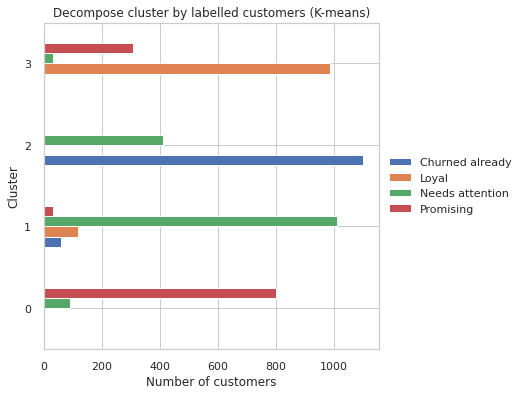

In [90]:
# Plot the cluster label with pre-defined manual labels 
dist=pd.crosstab(rfm_cluster_a['cluster'],rfm_cluster_a['label'])
dist.plot(kind='barh',figsize=(6,6))
plt.title('Decompose cluster by labelled customers (K-means)')
plt.xlabel('Number of customers')
plt.ylabel('Cluster')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show();

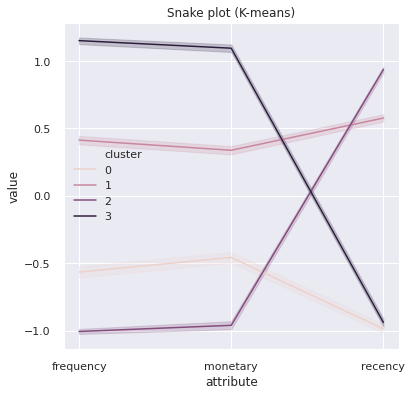

In [91]:
# Snake plot of standardised attribute 
# New dataframe is created which appends cluster labels to the standardised RFM dataframe 
sp=rfm_a2.reset_index(drop=True).assign(cluster=rfm_cluster_a['cluster'])
sp=pd.melt(sp.reset_index(),id_vars=['cluster'],
                    value_vars=['recency','frequency','monetary'],
                    var_name='attribute',
                    value_name='value')
# Plot 
sns.set(rc={'figure.figsize':(6,6)})
plt.title('Snake plot (K-means)')
sns.lineplot(x='attribute',y='value',hue='cluster',data=sp);

**Since K-means is the best performing clustering algorithms of all, further explore the difference in each attribute among the clusters.**

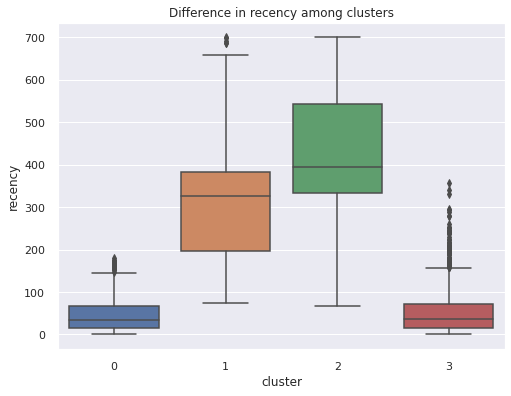

In [92]:
# Difference in recency among clusters
plt.figure(figsize=(8,6))
sns.boxplot(x='cluster',y='recency',data=rfm_cluster_a)
plt.title('Difference in recency among clusters')
plt.show();

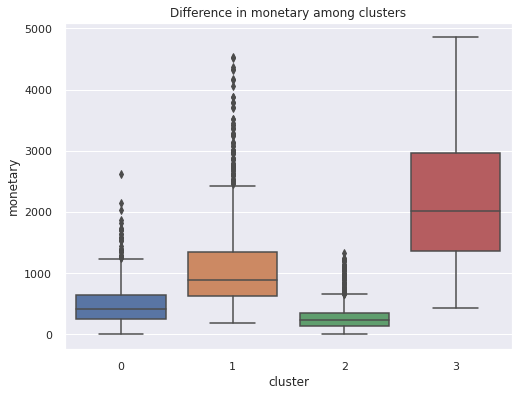

In [93]:
# Difference in monetary among clusters
plt.figure(figsize=(8,6))
sns.boxplot(x='cluster',y='monetary',data=rfm_cluster_a)
plt.title('Difference in monetary among clusters')
plt.show();

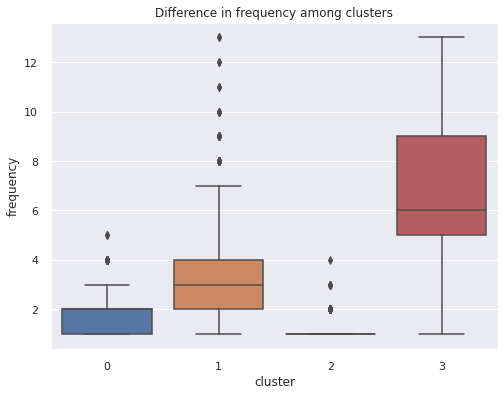

In [94]:
#Difference in frequency among clusters
plt.figure(figsize=(8,6))
sns.boxplot(x='cluster',y='frequency',data=rfm_cluster_a)
plt.title('Difference in frequency among clusters')
plt.show();

## 2. Hierarchy clustering 

In [95]:
# Compute the execution time, db index and silhouette score of hc
db2,slc2={},{}
for k in range(3,9):
    start_time=time.time()
    hc=AgglomerativeClustering(n_clusters=k, affinity='euclidean').fit(rfm_a2)
    print("--- %s seconds ---" % (time.time() - start_time))
    labels=hc.labels_
    clusters=hc.labels_
    db2[k]=davies_bouldin_score(rfm_a2,clusters)
    slc2[k]=silhouette_score(rfm_a2,clusters)

--- 0.6403419971466064 seconds ---
--- 0.6544363498687744 seconds ---
--- 0.6526925563812256 seconds ---
--- 0.659663200378418 seconds ---
--- 0.6572113037109375 seconds ---
--- 0.6435842514038086 seconds ---


In [158]:
# create a list for the execution time 
t2={}
t_hc=[0.640,0.654,0.652,0.659,0.657,0.643]
for i in range(3,9):
        t2[i]=t_hc[i-3]*1000

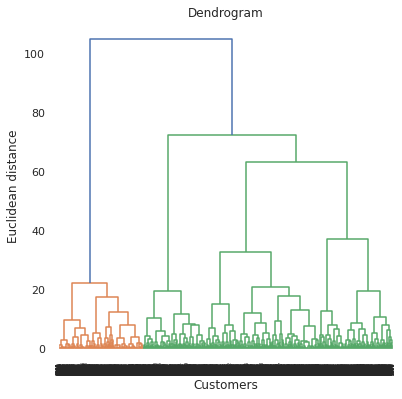

In [97]:
# Plot the dendrogram with ward method as ward method tries to minimise the variance within each cluster
#fig = plt.figure(figsize=(10,10))
dendrogram1 = sch.dendrogram(sch.linkage(rfm_a2, method  = "ward"))
plt.title('Dendrogram');plt.xlabel('Customers')
plt.ylabel('Euclidean distance')
plt.show();

### Profiling using Hierarchical clustering 

In [98]:
# Agglomerative clustering with 4 clusters 
hc=AgglomerativeClustering(n_clusters=4,affinity='euclidean')
y_hc=hc.fit_predict(rfm_a2)
# Convert the labels array to dataframe 
rfm_cluster_a2=rfm.assign(cluster=y_hc)

In [99]:
# Customer profile with hc when k=4
rfm_cluster_a2.groupby(['cluster']).agg({
    'recency':['mean','min','max'],
    'frequency':['mean','min','max'],
    'monetary':['mean','min','max','sum','count'],
})


recency          frequency             monetary                    \
               mean min  max      mean min max         mean      min      max   
cluster                                                                         
0         31.098618   1  160  2.499539   1  10   741.808345     6.20  4366.78   
1        296.540443  46  700  3.286399   1  13   913.772608    70.74  4511.76   
2         65.700546   1  538  7.754098   2  13  2671.346025  1038.92  4851.44   
3        417.184481  56  700  1.003167   1   2   248.589114     2.90  1230.33   

                            
                 sum count  
cluster                     
0         804862.054  1085  
1        1525086.482  1669  
2        2444281.613   915  
3         313968.051  1263

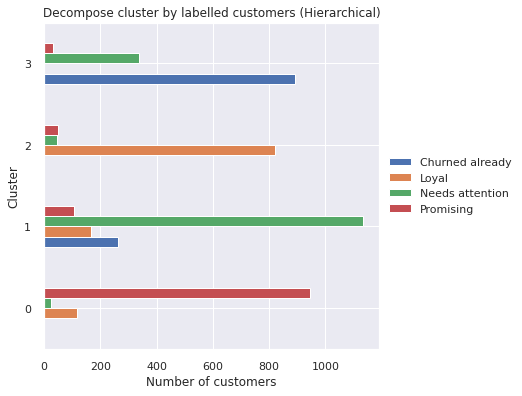

In [100]:
# Compare with manual labels
pd.crosstab(rfm_cluster_a2['cluster'],rfm_cluster_a2['label']).plot(kind='barh',figsize=(6,6))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Decompose cluster by labelled customers (Hierarchical)')
plt.xlabel('Number of customers')
plt.ylabel('Cluster')
plt.show();

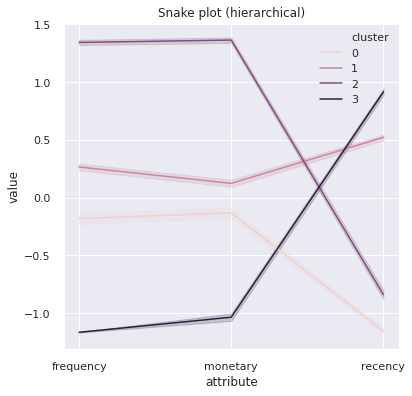

In [101]:
# Snake plot of standardised attribute 
sp2=rfm_a2.reset_index(drop=True).assign(cluster=rfm_cluster_a2['cluster'])
sp2=pd.melt(sp2.reset_index(),id_vars=['cluster'],
                    value_vars=['recency','frequency','monetary'],
                    var_name='attribute',
                    value_name='value')
# Plot
sns.set(rc={'figure.figsize':(6,6)})
plt.title('Snake plot (hierarchical)')
sns.lineplot(x='attribute',y='value',hue='cluster',data=sp2);

## 3. K-medoids 

In [102]:
# k-medoid execution time, db index and silhouette score 
db3,slc3={},{}
for k in range(3,9):
    start_time = time.time()
    kmed=KMedoids(n_clusters=k,random_state=0).fit(rfm_a2)
    print("--- %s seconds ---" % (time.time() - start_time))
    clusters=kmed.labels_  
    db3[k]=davies_bouldin_score(rfm_a2,clusters)
    slc3[k]=silhouette_score(rfm_a2,clusters)

--- 0.8163027763366699 seconds ---
--- 0.7928004264831543 seconds ---
--- 0.8029894828796387 seconds ---
--- 0.7921066284179688 seconds ---
--- 0.7951171398162842 seconds ---
--- 0.711057186126709 seconds ---


In [159]:
t3={}
t_kmed=[0.816,0.792,0.802,0.792,0.795,0.711]
for i in range(3,9):
        t3[i]=t_kmed[i-3]*1000

### Profiling using K-medoids

In [104]:
# K-medoids with 4 clusters 
kmed4=KMedoids(n_clusters=4,random_state=0).fit(rfm_a2)

In [105]:
# Construct cluster profile 
rfm_cluster_a3=rfm.assign(cluster=kmed4.labels_)
rfm_cluster_a3.groupby(['cluster']).agg({
    'recency':['mean','min','max'],
    'frequency':['mean','min','max'],
    'monetary':['mean','min','max','count'],
})

recency          frequency             monetary                   \
               mean min  max      mean min max         mean     min      max   
cluster                                                                        
0         59.238227   1  239  1.967682   1   6   535.532625    6.20  4366.78   
1         46.617893   1  253  6.836957   2  13  2263.534461  434.42  4851.44   
2        416.326478  46  700  1.179306   1   3   283.906492    2.90  1954.99   
3        317.205105  96  700  4.025524   1  13  1239.079901  181.35  4756.74   

               
        count  
cluster        
0        1083  
1        1196  
2        1556  
3        1097

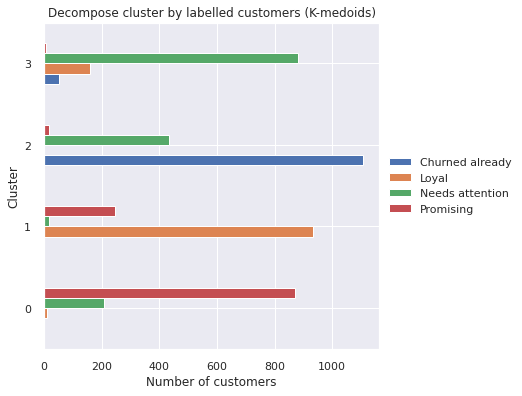

In [106]:
# Visualise the composition with manual label 
pd.crosstab(rfm_cluster_a3['cluster'],rfm_cluster_a3['label']).plot(kind='barh',figsize=(6,6))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Decompose cluster by labelled customers (K-medoids)')
plt.xlabel('Number of customers')
plt.ylabel('Cluster')
plt.show();

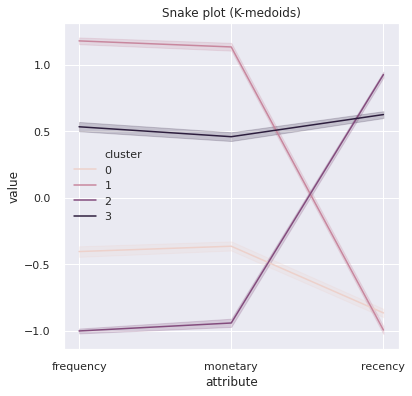

In [107]:
# Snake plot of standardised attribute 
sp3=rfm_a2.reset_index(drop=True).assign(cluster=rfm_cluster_a3['cluster'])
sp3=pd.melt(sp3.reset_index(),id_vars=['cluster'],
                    value_vars=['recency','frequency','monetary'],
                    var_name='attribute',
                    value_name='value')
# Plot
sns.set(rc={'figure.figsize':(6,6)})
plt.title('Snake plot (K-medoids)')
sns.lineplot(x='attribute',y='value',hue='cluster',data=sp3);

## Performance comparison

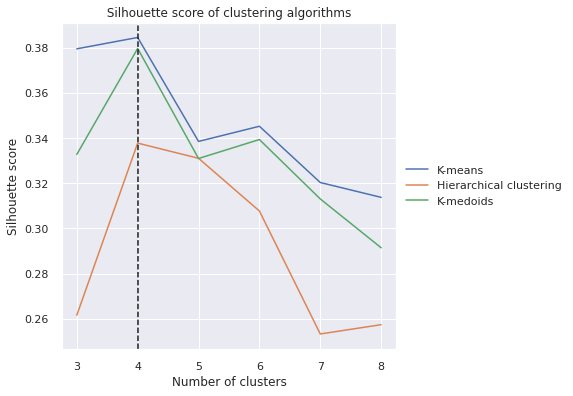

In [108]:
# Compare slc 
from collections import defaultdict
slc_all=defaultdict(list)
for i in (slc,slc2,slc3):
    for key,value in i.items():
        slc_all[key].append(value)

# plot 
slc_all=pd.DataFrame(slc_all).T
slc_all.columns=['K-means','Hierarchical clustering','K-medoids']
slc_all.plot(kind='line',figsize=(6,6))
plt.axvline(x=4,color='k',linestyle='--')
plt.title(' Silhouette score of clustering algorithms ')
plt.ylabel('Silhouette score')
plt.xlabel('Number of clusters')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show();

In [109]:
# SLC scores 
slc_all

,K-means,Hierarchical clustering,K-medoids
3,0.379482,0.261534,0.332713
4,0.384514,0.337735,0.379640
5,0.338484,0.331016,0.330918
6,0.345197,0.307673,0.339314
7,0.320286,0.253224,0.313012
8,0.313717,0.257341,0.291393


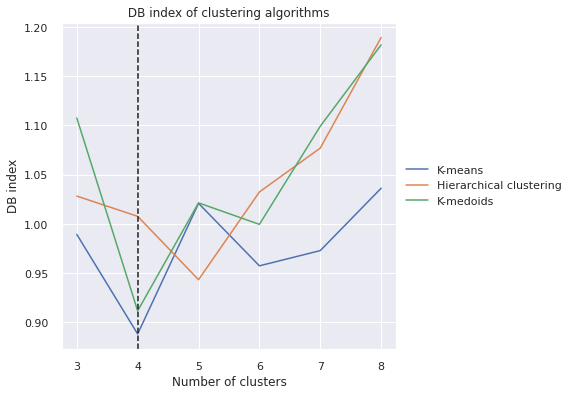

In [110]:
# Compare db 
db_all=defaultdict(list)
for i in (db,db2,db3):
    for key,value in i.items():
        db_all[key].append(value)

# plot 
db_all=pd.DataFrame(db_all).T
db_all.columns=['K-means','Hierarchical clustering','K-medoids']
db_all.plot(kind='line',figsize=(6,6))
plt.axvline(x=4,color='k',linestyle='--')
plt.title(' DB index of clustering algorithms ')
plt.ylabel('DB index')
plt.xlabel('Number of clusters')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show();

In [111]:
# DB index for all 
db_all

,K-means,Hierarchical clustering,K-medoids
3,0.989413,1.028309,1.107644
4,0.888278,1.007754,0.911754
5,1.020951,0.943380,1.021434
6,0.957481,1.032502,0.999592
7,0.972968,1.077078,1.099286
8,1.036315,1.189401,1.181932


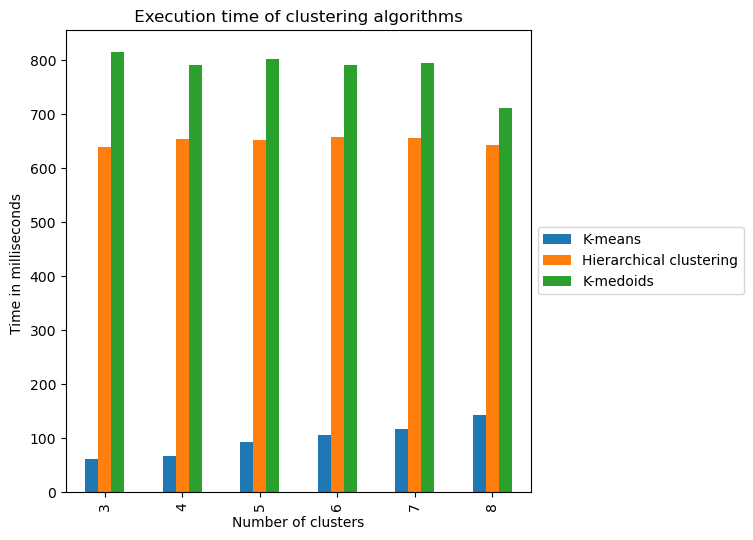

In [160]:
# compare time of execution 
time_all=defaultdict(list)
for i in (t,t2,t3):
    for key,value in i.items():
        time_all[key].append(value)

# plot 
time_all=pd.DataFrame(time_all).T
time_all.columns=['K-means','Hierarchical clustering','K-medoids']
time_all.plot(kind='bar',figsize=(6,6))
plt.title(' Execution time of clustering algorithms ')
plt.ylabel('Time in milliseconds ')
plt.xlabel('Number of clusters')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show();

## Part 2: Purchase prediction with classification 

Feature engineering aims to create features that would help distinugish different group of customers. 

Besides the RFM model which captures: 
* Recency: number of days between the last purchase and the analysis date (1st November 2011) 
* Monetary:total monetary consumption;
* Frequency: number of unique invoices

I've come up with several more features that i think would be helpful to characterise different customers. 

Time-related: 
* Inactivity: average inactive days between every unique invoice date. 
* Tenure: number of days between the first purchase and the analysis date. 

Frequency-related: 
* Seasonal purchase frequency: number of orders made in each season. From EDA in Section 3, seasonal fluctuations were observed. Therefore, the number of orders made in each season is counted. Winter covers from December to February, Spring covers from March to May and so forth.

Monetary: 
* Monthly: spending per month;
* Order: spending per order

Quantity-related: 
* Product diversity: the number of distinct products bought;
* Average quantity per order: average number of products bought 
* Total quantity: total number of products bought 

Categorical: 
* uk: uk customers are labelled 1, otherwise, 0
* cancelled: customers who have cancelled before are labelled 1, otherwise, 0
* cluster: the cluster labels generated in previous section. For customers in the same cluster, they might exhibit similar purchase pattern.   

    

### Target variable 

In [113]:
# Get the list of customers in clustering 
existing_customers=list(rfm_a.index)

In [114]:
# Extract transaction record of these customers
df_b2=df_b[df_b['customer_id'].isin(existing_customers)] # with november sales info 
df_d2=df_d[df_d['customer_id'].isin(existing_customers)] # without november sales info 

In [115]:
# Get target variable (November sales)
freq_monthly=pd.DataFrame(df_b2[['customer_id','invoice','my']].groupby(['customer_id','my'])['invoice'].nunique())
freq_monthly.rename(columns={'invoice':'freq_m'},inplace=True)
freq_monthly=freq_monthly.pivot_table(index=['customer_id'],columns='my',values='freq_m')

# For customers with sales>=1, they are labelled 1, otherwise, 0
freq_monthly['purchase']=np.where(freq_monthly['2011-11']>=1,1,0)

# Store ID and target variable 
Y=pd.DataFrame(freq_monthly['purchase']).reset_index()
ID=list(freq_monthly.index)

### Create user-based attributes

#### *RFM with cluster label*

In [116]:
# Use rfm dataframe with cluster labels generated from previous section 
prep=rfm_a.assign(cluster=labels_a1)

#### *Average inactivity (=interpurchase timing)*

In [117]:
## Calculate the difference between login dates
diff=pd.DataFrame(df_d2[['customer_id','date']]).drop_duplicates()
# calculate the difference between each unique date by user 
diff['diff']=diff.groupby('customer_id')['date'].diff(-1) * (-1)
# Since we have a lot of empty values, i.e. users with one record only, 
# fill those by subtract the date from Nov.1
diff.loc[diff["diff"].isnull(),'diff'] = pd.to_datetime(dt.date(2011,11,1))-pd.to_datetime(diff["date"])
# keep numbers only
diff['diff']=diff['diff'].dt.days
# calculate average 
add=pd.DataFrame(diff[['diff','customer_id']].groupby(['customer_id'])['diff'].mean().round(1))

#### *Tenure*

In [118]:
# Calculate the length of relationship 
df_tenure=df_d2.groupby('customer_id').date.min().reset_index()
df_tenure.columns=['customer_id','first_date']
df_tenure['tenure']=(pd.to_datetime(dt.date(2011,11,1))-pd.to_datetime(df_tenure['first_date'])).dt.days

#### *Seasonal purchase frequency*

In [119]:
# Purchase in a particular month 
month=pd.DataFrame(df_d2[['customer_id','invoice','month']].groupby(['customer_id','month'])['invoice'].nunique())
month.rename(columns={'invoice':'freq_m'},inplace=True)
month_new=month.pivot_table(index=['customer_id'],columns='month',values='freq_m')
month_new.columns=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

In [120]:
# Purchase in season 
season=pd.DataFrame()
season['winter']=month_new[['Dec','Jan','Feb']].sum(axis=1)
season['spring']=month_new[['Mar','Apr','May']].sum(axis=1)
season['summer']=month_new[['Jun','Jul','Aug']].sum(axis=1)
season['autumn']=month_new[['Sep','Oct','Nov']].sum(axis=1)
season=season.reset_index()

#### *Monetary* 

In [121]:
# Spending per order
money=pd.DataFrame(df_d2.groupby(['customer_id','invoice'])['amount'].sum())
add['monetary_order']=money.groupby(['customer_id'])['amount'].mean().values

In [122]:
# Spending per month 
add['monetary_monthly']=(df_d2.groupby(['customer_id','my'])['amount'].sum()).groupby('customer_id').mean()  

#### *Product diversity and Quantity*

In [123]:
# Total product diversity 
add['diversity']=df_d2.groupby(['customer_id'])['stockcode'].nunique()

# Average product quantity and total quantity
add['quantity_avg']=df_d2.groupby(['customer_id'])['quantity'].mean()
add['quantity_total']=df_d2.groupby(['customer_id'])['quantity'].sum()

#### *Cancelled before*

In [124]:
# Label customers who have cancelled before 1, otherwise 0  
cancelledid=list(df_cancelled.customer_id)
add['cancelled']=np.where(add.index.isin(cancelledid),1,0)

#### *UK or not*

In [125]:
# Label uk customers 1, non-uk customers 0
country2=df_d2.drop_duplicates(subset=['customer_id'])
country2['uk']=np.where(country2['country']=='United Kingdom',1,0)

#### Merge all features 

In [126]:
add=add.reset_index()
df_all=prep.merge(df_tenure[['customer_id','tenure']],on='customer_id')
df_all=df_all.merge(season,on='customer_id')
df_all=df_all.merge(add,on='customer_id')
df_all=df_all.merge(country2[['customer_id','uk']],on='customer_id')

### Feature selection 

In [127]:
# Drop customer id 
df_all_new=df_all.drop('customer_id',axis=1)

In [128]:
# keep a copy 
X=df_all_new.copy()

In [129]:
# calculate VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor    
vif=pd.DataFrame()
vif['VIF Factor'] = [variance_inflation_factor(X.values,i) for i in range(X.shape[1])]
vif['Features'] = X.columns
vif.round(2)

,VIF Factor,Features
0,10.64,recency
1,inf,frequency
2,16.99,monetary
3,6.50,cluster
4,17.10,tenure
5,inf,winter
6,inf,spring
7,inf,summer
8,inf,autumn
9,16.38,diff


In [130]:
# Drop high VIF variables 
X = X.drop(['frequency','monetary_monthly','uk','tenure'], axis = 1)
vif=pd.DataFrame()
vif['VIF Factor'] = [variance_inflation_factor(X.values,i) for i in range(X.shape[1])]
vif['Features'] = X.columns
vif.round(2)

,VIF Factor,Features
0,9.94,recency
1,15.08,monetary
2,6.39,cluster
3,2.10,winter
4,2.50,spring
5,2.33,summer
6,2.92,autumn
7,12.60,diff
8,4.19,monetary_order
9,3.46,diversity


In [131]:
# keep diff, drop the other 2 variables
X = X.drop(['monetary','recency'], axis = 1)
vif=pd.DataFrame()
vif['VIF Factor'] = [variance_inflation_factor(X.values,i) for i in range(X.shape[1])]
vif['Features'] = X.columns
vif.round(2)

,VIF Factor,Features
0,5.98,cluster
1,1.76,winter
2,2.17,spring
3,2.15,summer
4,2.72,autumn
5,2.86,diff
6,2.71,monetary_order
7,3.43,diversity
8,1.44,quantity_avg
9,4.64,quantity_total


In [132]:
# Drop all from the original df
df_all_new=df_all_new.drop(['frequency','monetary_monthly','tenure','recency','uk','monetary'],axis=1)

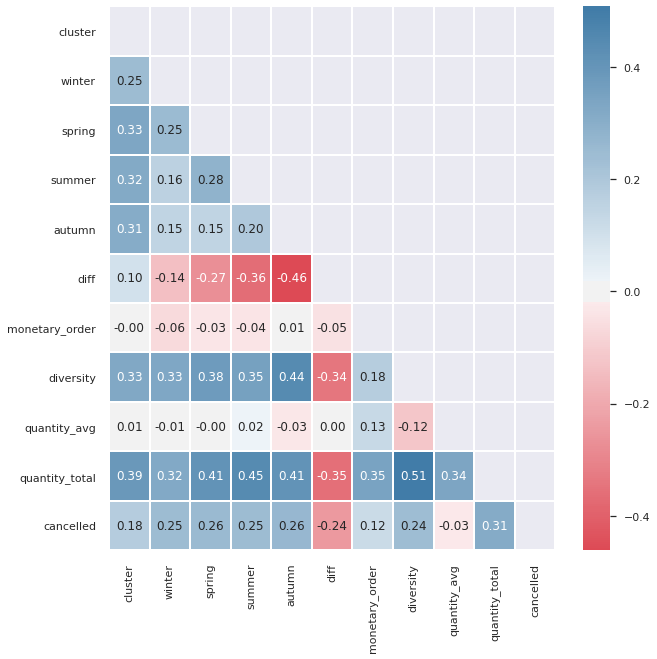

In [133]:
# Plot correlation matrix
fig, ax = plt.subplots(figsize=(10,10))
cmap=sns.diverging_palette(h_neg=10,
                          h_pos=240,
                          as_cmap=True)
mask=np.triu(np.ones_like(df_all_new.corr(),dtype=bool))
sns.heatmap(df_all_new.corr(),mask=mask,center=0,
           cmap=cmap,linewidths=1,
           annot=True,fmt='.2f')
plt.show();

### Check class imbalance

Class imbalance is expected as non-buyers typically outnumber buyers in reality, however, I chose not to adjust for the class imbalance by downsampling the majority class but to use the embedded sklearn function to set the 'class-weight' parameter to *balanced* .

In [134]:
# Get the target variable 
target=Y.purchase
# Get all the features
features=df_all_new 

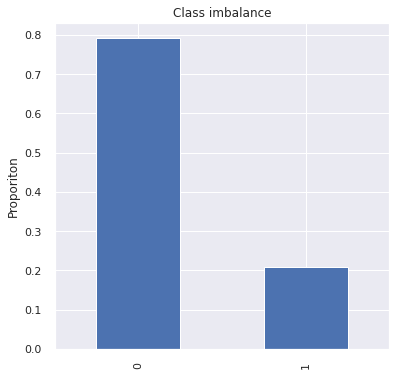

In [135]:
# Plot the class weight 
(Y.purchase.value_counts()/len(Y)).plot(kind='bar')
plt.ylabel('Proporiton')
plt.title('Class imbalance')
plt.show();

## Classification

In [136]:
# Split the dataset into train and test set
train_X,test_X,train_Y,test_Y=train_test_split(features,target,test_size=0.3,random_state=0,stratify=target)

In [137]:
for i in (train_X,test_X,train_Y,test_Y):
    print(i.shape)

(3452, 11)
(1480, 11)
(3452,)
(1480,)


In [138]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# Fit on training set only.
scaler.fit(train_X)
# Apply transform to both the training set and the test set.
train_X = scaler.transform(train_X)
test_X = scaler.transform(test_X)

StandardScaler()

In [139]:
# 5-fold cross validation on training set to compare model performance 
SEED=0

classifiers = [
    LogisticRegression(random_state=SEED,class_weight='balanced'),
    GaussianNB(),
    DecisionTreeClassifier(random_state=SEED,class_weight='balanced'),
    RandomForestClassifier(random_state=SEED,class_weight='balanced'),
    AdaBoostClassifier(random_state=SEED),
    GradientBoostingClassifier(random_state=SEED)
    ]

log_cols=["Classifier", "CV score", "SD"]
log = pd.DataFrame(columns=log_cols)

for clf in classifiers:
    print("="*30)
    print(clf)

    print('****Results****')
    cv_score = cross_val_score(clf,train_X,train_Y,cv=5,scoring='accuracy')
    print("CV score: {:.4%}, SD:{:.4%}".format(cv_score.mean(), cv_score.std()))
    log_entry = pd.DataFrame([[clf, cv_score.mean(), cv_score.std()]], columns=log_cols)
    log = log.append(log_entry)
print("="*30)

LogisticRegression(class_weight='balanced', random_state=0)
****Results****
CV score: 66.4245%, SD:1.8174%
GaussianNB()
****Results****
CV score: 70.9728%, SD:1.4503%
DecisionTreeClassifier(class_weight='balanced', random_state=0)
****Results****
CV score: 71.4942%, SD:1.3150%
RandomForestClassifier(class_weight='balanced', random_state=0)
****Results****
CV score: 79.1426%, SD:0.5408%
AdaBoostClassifier(random_state=0)
****Results****
CV score: 79.4034%, SD:0.4803%
GradientBoostingClassifier(random_state=0)
****Results****
CV score: 79.4030%, SD:0.9556%


In [140]:
# Check the values 
log.sort_values(by='CV score', ascending=False, inplace=True)
log.reset_index(drop=True, inplace=True)
log

,Classifier,CV score,SD
0,AdaBoostClassifier(random_state=0),0.794034,0.004803
1,GradientBoostingClassifier(random_state=0),0.794030,0.009556
2,RandomForestClassifier(class_weight='balanced'...,0.791426,0.005408
3,DecisionTreeClassifier(class_weight='balanced'...,0.714942,0.013150
4,GaussianNB(),0.709728,0.014503
5,"LogisticRegression(class_weight='balanced', ra...",0.664245,0.018174


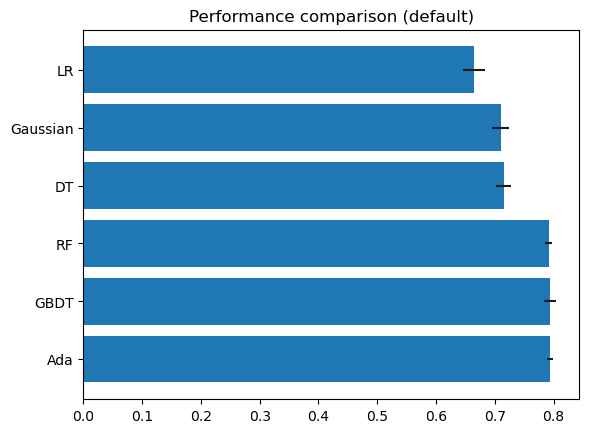

In [156]:
# Plot and compare the results 
plt.rcdefaults()
fig,ax=plt.subplots()
ax.barh(np.arange(len(log)),log['CV score'],xerr=log['SD'],align='center')
ax.set_yticks(np.arange(len(log)))
ax.set_yticklabels(['Ada','GBDT','RF','DT','Gaussian','LR'])
ax.set_title('Performance comparison (default)')
plt.show();

### Hyper tunning (Randomizedsearch with 5-fold cross-validation) 

### Logistic regression 

In [142]:
LR= LogisticRegression(random_state=0,class_weight='balanced')

params_lr = {'max_iter': [50,100,150,200],
            'C': [ 0.001,0.01, 0.1, 1, 10],
            'penalty':['l1', 'l2', 'elasticnet', 'none']}
# use RandomizedSearchCV 
lr_gs=RandomizedSearchCV(LR, params_lr, cv=5,n_jobs=-1,n_iter=100,random_state=0)
#fit model to trainning data
lr_gs.fit(train_X,train_Y)
#save the best model
lr_best = lr_gs.best_estimator_ 
print("Best: %f using %s" % (lr_gs.best_score_, lr_gs.best_params_))
# model performance improves when lower penalty C 

RandomizedSearchCV(cv=5,
                   estimator=LogisticRegression(class_weight='balanced',
                                                random_state=0),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'C': [0.001, 0.01, 0.1, 1, 10],
                                        'max_iter': [50, 100, 150, 200],
                                        'penalty': ['l1', 'l2', 'elasticnet',
                                                    'none']},
                   random_state=0)

Best: 0.687424 using {'penalty': 'l2', 'max_iter': 50, 'C': 0.001}


### Random forest 

In [143]:
rf = RandomForestClassifier(random_state=0,class_weight='balanced')
from sklearn.model_selection import RandomizedSearchCV

param_grid=[{
    'n_estimators':[50,100,150,200],
    'bootstrap':[True,False],
    'criterion':['gini'],
    'max_features':['auto'],
    'min_samples_leaf':[10,15,20,25,30,35],
    'min_samples_split':[5,10,15,20,25,30]}]

rs = RandomizedSearchCV(rf,param_distributions=param_grid,
                        cv=5,verbose=1,n_jobs=-1, scoring='accuracy',random_state=0)
#Best parameters 
rs.fit(train_X,train_Y)

#Best parameters 
rs_best=rs.best_estimator_
print("Best: %f using %s" % (rs.best_score_,rs.best_params_))

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    6.2s finished


RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(class_weight='balanced',
                                                    random_state=0),
                   n_jobs=-1,
                   param_distributions=[{'bootstrap': [True, False],
                                         'criterion': ['gini'],
                                         'max_features': ['auto'],
                                         'min_samples_leaf': [10, 15, 20, 25,
                                                              30, 35],
                                         'min_samples_split': [5, 10, 15, 20,
                                                               25, 30],
                                         'n_estimators': [50, 100, 150, 200]}],
                   random_state=0, scoring='accuracy', verbose=1)

Best: 0.742465 using {'n_estimators': 200, 'min_samples_split': 20, 'min_samples_leaf': 10, 'max_features': 'auto', 'criterion': 'gini', 'bootstrap': True}


### Decision Tree 

In [144]:
### Decision Tree 
DT=DecisionTreeClassifier(random_state=0,class_weight='balanced')
params_tree={'max_depth':[3,5,7,10,15],
           'max_features':['auto'],
    'min_samples_leaf':[10,15,20,25,30,35],
    'min_samples_split':[5,10,15,20,25,30],
          'max_leaf_nodes':[3,5,10,15,20,25],
            'criterion':['gini','entropy']}

tree_gs=RandomizedSearchCV(DT,params_tree,cv=5,n_iter=200, random_state=0)
#fit model to trainning data
tree_gs.fit(train_X,train_Y)
#save the best model
tree_best = tree_gs.best_estimator_
print("Best: %f using %s" % (tree_gs.best_score_, tree_gs.best_params_))

RandomizedSearchCV(cv=5,
                   estimator=DecisionTreeClassifier(class_weight='balanced',
                                                    random_state=0),
                   n_iter=200,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [3, 5, 7, 10, 15],
                                        'max_features': ['auto'],
                                        'max_leaf_nodes': [3, 5, 10, 15, 20,
                                                           25],
                                        'min_samples_leaf': [10, 15, 20, 25, 30,
                                                             35],
                                        'min_samples_split': [5, 10, 15, 20, 25,
                                                              30]},
                   random_state=0)

Best: 0.689749 using {'min_samples_split': 5, 'min_samples_leaf': 15, 'max_leaf_nodes': 25, 'max_features': 'auto', 'max_depth': 7, 'criterion': 'entropy'}


### Gaussian GB 

In [145]:
nb_classifier = GaussianNB()

params_NB = {'var_smoothing': np.logspace(0,-20, num=20)}

gs_NB = RandomizedSearchCV(nb_classifier, 
                     params_NB, 
                     cv=5,
                     verbose=1, 
                     scoring='accuracy',random_state=0)

gs_NB.fit(train_X, train_Y)
#save the best model
gb_best = gs_NB.best_estimator_
print("Best: %f using %s" % (gs_NB.best_score_, gs_NB.best_params_))

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.1s finished


RandomizedSearchCV(cv=5, estimator=GaussianNB(),
                   param_distributions={'var_smoothing': array([1.00000000e+00, 8.85866790e-02, 7.84759970e-03, 6.95192796e-04,
       6.15848211e-05, 5.45559478e-06, 4.83293024e-07, 4.28133240e-08,
       3.79269019e-09, 3.35981829e-10, 2.97635144e-11, 2.63665090e-12,
       2.33572147e-13, 2.06913808e-14, 1.83298071e-15, 1.62377674e-16,
       1.43844989e-17, 1.27427499e-18, 1.12883789e-19, 1.00000000e-20])},
                   random_state=0, scoring='accuracy', verbose=1)

Best: 0.726240 using {'var_smoothing': 0.08858667904100828}


### Gradient boosting 

In [146]:
GB=GradientBoostingClassifier()

params_GB={'max_depth':[3,4,5,6,7,8], 
           'n_estimators':[20,30,50,100,150,200],
        'min_samples_split':[3,5,10],
        'min_samples_leaf':[3,5,10,15,20],
          }

GB_gs=RandomizedSearchCV(GB,params_GB,cv=5, n_jobs=-1,random_state=0)
#fit model to trainning data
GB_gs.fit(train_X,train_Y)
#save the best model
GB_best = GB_gs.best_estimator_ 
print("Best: %f using %s" % (GB_gs.best_score_, GB_gs.best_params_))

RandomizedSearchCV(cv=5, estimator=GradientBoostingClassifier(), n_jobs=-1,
                   param_distributions={'max_depth': [3, 4, 5, 6, 7, 8],
                                        'min_samples_leaf': [3, 5, 10, 15, 20],
                                        'min_samples_split': [3, 5, 10],
                                        'n_estimators': [20, 30, 50, 100, 150,
                                                         200]},
                   random_state=0)

Best: 0.796638 using {'n_estimators': 50, 'min_samples_split': 10, 'min_samples_leaf': 10, 'max_depth': 4}


### Adaboosting 

In [147]:
import numpy as np

ADA=AdaBoostClassifier(base_estimator=nb_classifier)

params_Ada={"learning_rate": np.arange(0.01, 1, 0.01),
          "n_estimators": [20,50,100,150,200,300]
}

Ada_gs=RandomizedSearchCV(ADA,params_Ada,cv=5, n_jobs=-1,random_state=0)
#fit model to trainning data
Ada_gs.fit(train_X,train_Y)
#save the best model
Ada_best = Ada_gs.best_estimator_ 
print("Best: %f using %s" % (Ada_gs.best_score_, Ada_gs.best_params_))


RandomizedSearchCV(cv=5,
                   estimator=AdaBoostClassifier(base_estimator=GaussianNB()),
                   n_jobs=-1,
                   param_distributions={'learning_rate': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
       0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
       0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]),
                                        'n_estimators': [20, 50, 100, 150, 200,
                                                         300]},
       

Best: 0.789393 using {'n_estimators': 100, 'learning_rate': 0.16}


### Performance evaluation (test data)

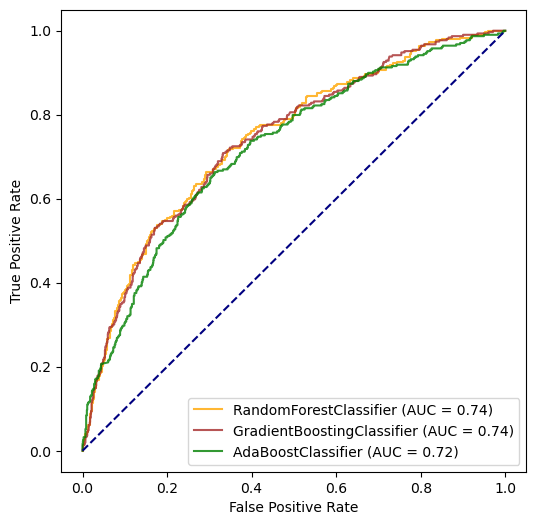

In [148]:
# Plot classifier ROC
plt.figure(figsize=(6, 6))
ax = plt.gca()
RF = plot_roc_curve(rs_best, test_X, test_Y, ax=ax, alpha=0.8, color='orange')
GBDT = plot_roc_curve(GB_best, test_X, test_Y, ax=ax, alpha=0.8, color='brown')
ADA = plot_roc_curve(Ada_best, test_X, test_Y, ax=ax, alpha=0.8, color='green')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.show();

=== Confusion Matrix (Test) ===
 ===Classification Report=== 
              precision    recall  f1-score   support

           0       0.87      0.81      0.84      1171
           1       0.43      0.55      0.48       309

    accuracy                           0.75      1480
   macro avg       0.65      0.68      0.66      1480
weighted avg       0.78      0.75      0.76      1480



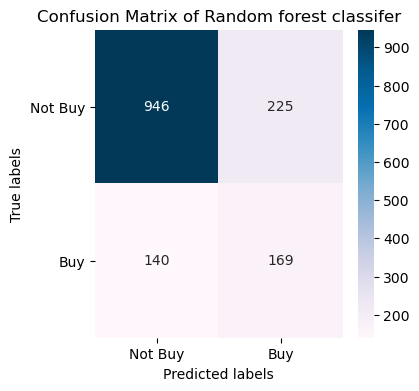

In [149]:
# Create confusion matrix of the testing set (random forest)
print("=== Confusion Matrix (Test) ===")
rs_predict= rs_best.predict(test_X)
cm_test = confusion_matrix(test_Y,rs_predict)

# Plot the confusion matrix 
plt.figure(figsize=(4, 4))
ax= plt.subplot()
sns.heatmap(cm_test, annot=True, ax = ax, fmt='g',cmap='PuBu')
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix of Random forest classifer')
plt.setp(ax.get_yticklabels(), rotation=360, ha="right",rotation_mode="anchor")
ax.xaxis.set_ticklabels(['Not Buy','Buy']); ax.yaxis.set_ticklabels(['Not Buy','Buy'])

# # Check classification report 
print(" ===Classification Report=== ")
print(classification_report(test_Y, rs_predict))
plt.show();

=== Confusion Matrix (Test) ===
 ===Classification Report=== 
              precision    recall  f1-score   support

           0       0.82      0.95      0.88      1171
           1       0.54      0.21      0.30       309

    accuracy                           0.80      1480
   macro avg       0.68      0.58      0.59      1480
weighted avg       0.76      0.80      0.76      1480



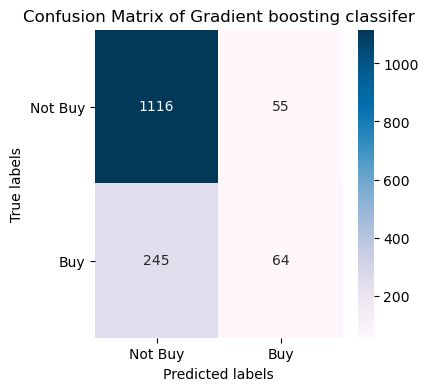

In [150]:
# Create confusion matrix of the testing set (gradient boosting)
print("=== Confusion Matrix (Test) ===")
GB_predict= GB_best.predict(test_X)
cm_test = confusion_matrix(test_Y,GB_predict)

# Plot the confusion matrix 
plt.figure(figsize=(4, 4))
ax= plt.subplot()
sns.heatmap(cm_test, annot=True, ax = ax, fmt='g',cmap='PuBu')
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix of Gradient boosting classifer')
plt.setp(ax.get_yticklabels(), rotation=360, ha="right",rotation_mode="anchor")
ax.xaxis.set_ticklabels(['Not Buy','Buy']); ax.yaxis.set_ticklabels(['Not Buy','Buy'])

# # Check classification report 
print(" ===Classification Report=== ")
print(classification_report(test_Y, GB_predict))
plt.show();

=== Confusion Matrix (Test) ===
 ===Classification Report=== 
              precision    recall  f1-score   support

           0       0.82      0.95      0.88      1171
           1       0.54      0.21      0.30       309

    accuracy                           0.80      1480
   macro avg       0.68      0.58      0.59      1480
weighted avg       0.76      0.80      0.76      1480



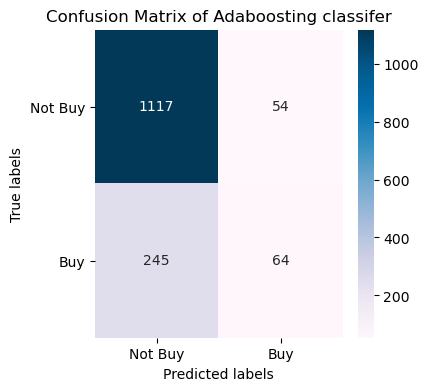

In [151]:
# Create confusion matrix of the testing set (adaboosting)
print("=== Confusion Matrix (Test) ===")
Ada_predict= Ada_best.predict(test_X)
cm_test = confusion_matrix(test_Y,Ada_predict)

# Plot the confusion matrix 
plt.figure(figsize=(4, 4))
ax= plt.subplot()
sns.heatmap(cm_test, annot=True, ax = ax, fmt='g',cmap='PuBu')
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix of Adaboosting classifer')
plt.setp(ax.get_yticklabels(), rotation=360, ha="right",rotation_mode="anchor")
ax.xaxis.set_ticklabels(['Not Buy','Buy']); ax.yaxis.set_ticklabels(['Not Buy','Buy'])

# # Check classification report 
print(" ===Classification Report=== ")
print(classification_report(test_Y, Ada_predict))
plt.show();

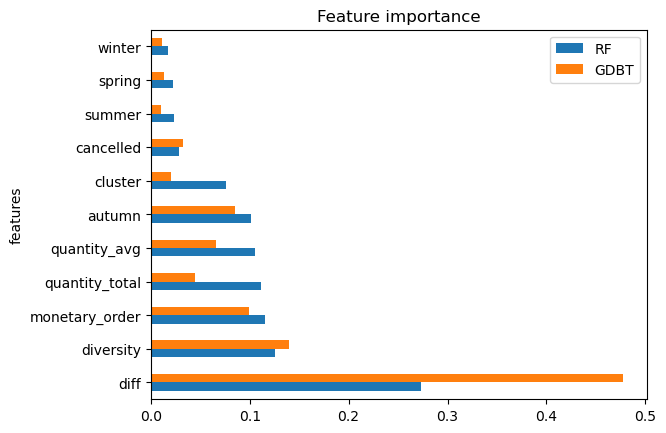

In [152]:
# Feature importance analysis 
# get importance
importance_rs = list(rs_best.feature_importances_)
importance_gb=list(GB_best.feature_importances_)
x_labels=list(features.columns)
fi=pd.DataFrame(list(zip(x_labels,importance_rs,importance_gb)),
              columns=['features','RF','GDBT']).sort_values(by='RF',ascending=False)
fi=fi.set_index('features')
fi
# plot feature importance
fi.plot(kind='barh')
plt.title('Feature importance')
plt.show();

In [153]:
fi

,RF,GDBT
features,,
diff,0.272809,0.477503
diversity,0.125745,0.139462
monetary_order,0.115068,0.099170
quantity_total,0.111294,0.044499
quantity_avg,0.105798,0.065916
autumn,0.101450,0.085272
cluster,0.075550,0.020142
cancelled,0.028674,0.032577
summer,0.023639,0.010829


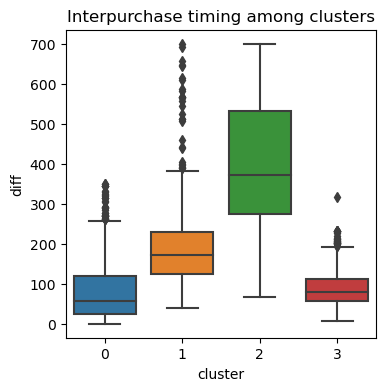

In [154]:
plt.figure(figsize=(4,4))
sns.boxplot(x='cluster',y='diff',data=features)
plt.title('Interpurchase timing among clusters')
plt.show();

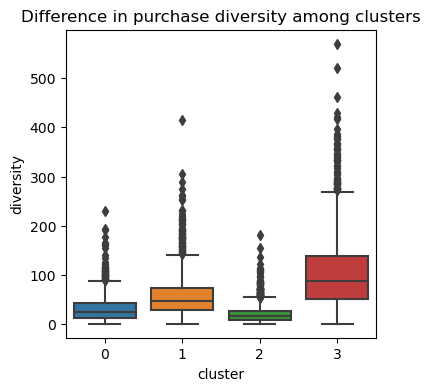

In [155]:
plt.figure(figsize=(4,4))
sns.boxplot(x='cluster',y='diversity',data=features)
plt.title('Difference in purchase diversity among clusters')
plt.show();